In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as opt
import torch.nn.functional as F
from torchvision.io import read_image
from torchvision import transforms
from tqdm.notebook import tqdm
from PIL import Image
import optuna
from optuna.trial import TrialState

In [2]:
random.seed(2020)

In [2]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [4]:
resize_image = transforms.Resize(size=(227, 227))

In [5]:
def calculate_mean(dataset):
    mean = torch.Tensor([0.,0.,0.])
    
    num_samples = len(dataset)
    for i in range(num_samples):
        image, _ = dataset[i]
        image = image.type(torch.FloatTensor) / 255
        
        for j in range(3):
            mean[j] += torch.mean(image[j, :, :])
            
    mean = mean / num_samples
    return mean

In [6]:
def subtract_mean(image, mean):
    normed_image = torch.zeros(image.size())
    image = image.type(torch.FloatTensor) / 255
    
    for j in range(3):
        normed_image[j] = image[j, :, :] - mean[j]
    return normed_image

In [7]:
class AdienceDataset(Dataset):
    def __init__(self, annot_file, img_dir, train=False, transform=None):
        self.img_lbls = pd.read_csv(annot_file, header=None)
        self.img_lbls[2] = [x.split('.')[1] for x in self.img_lbls[0]]
        self.img_dir = img_dir
        self.transform = transform
        self.is_train = train
        self.mean = torch.Tensor([0.,0.,0.])
    
    def __len__(self):
        return len(self.img_lbls)
    
    def __getitem__(self, idx):
        img_file = self.img_lbls.iloc[idx, 0]
        face_id = self.img_lbls.iloc[idx, 2]
        img_path = os.path.join(self.img_dir, img_file)
        image = read_image(img_path)
#         image = resize_image(image)
        label = self.img_lbls.iloc[idx, 1]
        
        if self.is_train:
            try:
                positive_list = self.img_lbls[self.img_lbls.iloc[:, 2] == face_id].index.values
                positive_list = np.setdiff1d(positive_list, np.array([idx]))
                positive_item = random.choice(positive_list)
            except IndexError:
                positive_list = self.img_lbls[self.img_lbls.iloc[:, 1] == label].index.values
                positive_item = random.choice(positive_list)
            positive_img = self.img_lbls.iloc[positive_item, 0]
            pos_img_path = os.path.join(self.img_dir, positive_img)
            pos_image = read_image(pos_img_path)
            
            negative_list = self.img_lbls[self.img_lbls.iloc[:, 1] != label].index.values
            negative_item = random.choice(negative_list)
            negative_img = self.img_lbls.iloc[negative_item, 0]
            neg_img_path = os.path.join(self.img_dir, negative_img)
            neg_image = read_image(neg_img_path)

            if self.transform:
                image = self.transform(image, self.mean)
                pos_image = self.transform(pos_image, self.mean)
                neg_image = self.transform(neg_image, self.mean)
                
            return image, pos_image, neg_image, label
        else:
            if self.transform:
                image = self.transform(image, self.mean)

            return image, label
    
    def set_mean(self, mean):
        self.mean = mean

In [11]:
img_lbls = pd.read_csv("../train.csv", header=None)
img_lbls[2] = [x.split('.')[1] for x in img_lbls[0]]
print(len(img_lbls))
i = 0
male = 0
female = 0

for idx in range(len(img_lbls)):
    img_file = img_lbls.iloc[idx, 0]
    face_id = img_lbls.iloc[idx, 2]
    img_path = os.path.join("../cropped_Adience/", img_file)
    image = read_image(img_path)
    label = img_lbls.iloc[idx, 1]

    try:
        positive_list = img_lbls[img_lbls.iloc[:, 2] == face_id].index.values
        positive_list = np.setdiff1d(positive_list, np.array([idx]))
        positive_item = random.choice(positive_list)
    except IndexError:
        i += 1
        if label == 0:
            male += 1
        else:
            female += 1
        
#         positive_list = self.img_lbls[self.img_lbls.iloc[:, 1] == label].index.values
#         positive_item = random.choice(positive_list)

print(i)
print(male)
print(female)

13973
797
383
414


In [8]:
train_data = AdienceDataset("../train.csv", "../cropped_Adience/", train=True)
# test_data = AdienceDataset("../test.csv", "../cropped_Adience/")
# val_data = AdienceDataset("../val.csv", "../cropped_Adience/")

In [8]:
train_data = AdienceDataset("../train.csv", "../cropped_Adience/", train=True, transform=subtract_mean)
test_data = AdienceDataset("../test.csv", "../cropped_Adience/", train=False, transform=subtract_mean)
val_data = AdienceDataset("../val.csv", "../cropped_Adience/", train=True, transform=subtract_mean)

In [9]:
# mean = calculate_mean(train_data)
mean = torch.Tensor([0.5062, 0.3581, 0.3099])
mean

tensor([0.5062, 0.3581, 0.3099])

In [10]:
train_data.set_mean(mean)
test_data.set_mean(mean)
val_data.set_mean(mean)

In [11]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin
        
    def calc_euclidean(self, x1, x2):
        return (x1 - x2).pow(2).sum(1)
    
    def forward(self, anchor, positive, negative):
        distance_positive = self.calc_euclidean(anchor, positive)
        distance_negative = self.calc_euclidean(anchor, negative)
        losses = torch.relu(distance_positive - distance_negative + self.margin)

        return losses.mean()

In [12]:
class CombinedLoss(nn.Module):
    def __init__(self, alpha=1.0, beta=1.0):
        super(CombinedLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.triplet = TripletLoss(margin=1.0)
        self.classification = nn.CrossEntropyLoss()
        
    def forward(self, anchor, positive, negative, classification_out, labels):
        triplet_loss = self.triplet(anchor, positive, negative)
        classification_loss = self.classification(classification_out, labels)
        total_loss = (self.alpha * triplet_loss) + (self.beta * classification_loss)
        
        return total_loss

In [13]:
class Net(nn.Module):
    def __init__(self, num_channels, num_classes):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(num_channels, 96, kernel_size=7, stride=4)
        self.conv2 = nn.Conv2d(96, 256, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(256, 384, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2)
        self.norm = nn.LocalResponseNorm(5, alpha=0.0001, beta=0.75)
        
        self.fc6 = nn.Linear(in_features=13824, out_features=512)
        self.fc7 = nn.Linear(in_features=512, out_features=512)
        self.fc8 = nn.Linear(in_features=512, out_features=num_classes)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.norm(x)
        
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.norm(x)
        
        x = self.conv3(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = torch.flatten(x, 1)
        x = self.fc6(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc7(x)
        x_triplet = x
        x = self.relu(x)
        x = self.dropout(x)
        
        x_classification = self.fc8(x)
        
        return x_triplet, x_classification

In [14]:
def init_weights(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.kaiming_normal_(m.weight)

In [15]:
# best_loss = 1.0
best_loss = 0.4775232970714569
def objective(trial):
    model = Net(3, 2)
    model.apply(init_weights)
    model = torch.jit.script(model).to(device)
    
    lr = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
    mom = trial.suggest_float('momentum', 0.7, 0.99)
    wd = trial.suggest_float('weight_decay', 1e-5, 1e-1, log=True)
    optimizer = opt.SGD(model.parameters(), lr=lr, momentum=mom, weight_decay=wd)
    criterion = torch.jit.script(CombinedLoss())
    
    batch_size = trial.suggest_int('batch_size', 10, 100)
#     test_loader = DataLoader(test_data, batch_size=batch_size)
    
    num_epochs = trial.suggest_int('num_epochs', 10, 100)
    print("Learning rate: "+ str(lr))
    print("Momentum: "+ str(mom))
    print("Weight decay: "+ str(wd))
    print("Batch size: "+ str(batch_size))
    print("Number of epochs: "+ str(num_epochs))
    
    for epoch in tqdm(range(num_epochs), desc="Epochs"):
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
        val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=4)
        
        # train(model, optim, train_loader)
        # training loop
        running_loss = []
        running_accu = []
        
        model.train()
        for step, (anchor_img, positive_img, negative_img, anchor_label) in enumerate(tqdm(train_loader, desc="Training", leave=False)):
            anchor_img, positive_img, negative_img, anchor_label = anchor_img.to(device), positive_img.to(device), negative_img.to(device), anchor_label.to(device)

            optimizer.zero_grad()
            anchor_out, anchor_pred = model(anchor_img)
            positive_out, _ = model(positive_img)
            negative_out, _ = model(negative_img)
            
            pred = torch.argmax(anchor_pred, 1)
            accuracy = torch.eq(pred, anchor_label).sum() / len(anchor_img)

#             print(anchor_out.shape, positive_out.shape, negative_out.shape, anchor_pred.shape, anchor_label.shape)
            loss = criterion(anchor_out, positive_out, negative_out, anchor_pred, anchor_label)
            loss.backward()
            optimizer.step()

            running_accu.append(accuracy.cpu().detach().numpy())
            running_loss.append(loss.cpu().detach().numpy())
        print("Epoch: {}/{} - Loss: {:.4f} - Accuracy: {:.4f}".format(epoch+1, num_epochs, np.mean(running_loss), np.mean(running_accu)))
        
        # accuracy = test(model, val_loader)
        # validation loop
        val_loss = []
        val_accu = []

        model.eval()
        with torch.no_grad():
            for img, pos_img, neg_img, label in tqdm(val_loader):
                img, pos_img, neg_img, label = img.to(device), pos_img.to(device), neg_img.to(device), label.to(device)
                
                anchor, output = model(img)
                pos, _ = model(pos_img)
                neg, _ = model(neg_img)
                
                pred = torch.argmax(output, 1)
                accuracy = torch.eq(pred, label).sum() / len(img)
                
                loss = criterion(anchor, pos, neg, output, label)
                
                val_accu.append(accuracy.cpu().detach().numpy())
                val_loss.append(loss.cpu().detach().numpy())
        val_accu = np.mean(val_accu)
        val_loss = np.mean(val_loss)
        print("Val Loss: {:.4f} - Val Accuracy: {:.4f}".format(val_loss, val_accu))
        
        trial.report(val_loss, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    
    global best_loss
    if val_loss < best_loss:
        best_loss = val_loss
        print("Saving best model...")
        torch.save({"model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict()},
                   "../contrastive_model_4.pth")
            
    return val_loss

In [16]:
study = optuna.create_study(direction='minimize',
                            study_name='contrastive-loss-libfaceid-study',
                            storage='sqlite:///study.db',
                            load_if_exists=True)
study.optimize(objective, n_trials=23)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

# Display the study statistics
print("\nStudy statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

[I 2023-10-06 19:07:12,626] Using an existing study with name 'contrastive-loss-libfaceid-study' instead of creating a new one.


Learning rate: 0.009612893546491062
Momentum: 0.7902601353661358
Weight decay: 0.005165177345350873
Batch size: 52
Number of epochs: 81


Epochs:   0%|          | 0/81 [00:00<?, ?it/s]

Training:   0%|          | 0/269 [00:00<?, ?it/s]

Epoch: 1/81 - Loss: 1.6282 - Accuracy: 0.5379


  0%|          | 0/34 [00:00<?, ?it/s]

[I 2023-10-06 19:08:02,062] Trial 28 pruned. 


Val Loss: 1.5049 - Val Accuracy: 0.5697
Learning rate: 0.0026872222293176313
Momentum: 0.7673486583920576
Weight decay: 0.00017458092322958997
Batch size: 67
Number of epochs: 93


Epochs:   0%|          | 0/93 [00:00<?, ?it/s]

Training:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch: 1/93 - Loss: 1.6011 - Accuracy: 0.5357


  0%|          | 0/27 [00:00<?, ?it/s]

Val Loss: 1.4255 - Val Accuracy: 0.5404


Training:   0%|          | 0/209 [00:00<?, ?it/s]

Epoch: 2/93 - Loss: 1.4280 - Accuracy: 0.5688


  0%|          | 0/27 [00:00<?, ?it/s]

[I 2023-10-06 19:09:22,572] Trial 29 pruned. 


Val Loss: 1.3517 - Val Accuracy: 0.6267
Learning rate: 0.0012474541083382481
Momentum: 0.7207452597432225
Weight decay: 0.00014848929549529164
Batch size: 46
Number of epochs: 63


Epochs:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/304 [00:00<?, ?it/s]

Epoch: 1/63 - Loss: 1.6697 - Accuracy: 0.5340


  0%|          | 0/38 [00:00<?, ?it/s]

[I 2023-10-06 19:10:06,334] Trial 30 pruned. 


Val Loss: 1.5834 - Val Accuracy: 0.5357
Learning rate: 0.005819650914714708
Momentum: 0.8482087516953732
Weight decay: 3.4316347736032306e-05
Batch size: 27
Number of epochs: 18


Epochs:   0%|          | 0/18 [00:00<?, ?it/s]

Training:   0%|          | 0/518 [00:00<?, ?it/s]

Epoch: 1/18 - Loss: 1.8076 - Accuracy: 0.5357


  0%|          | 0/65 [00:00<?, ?it/s]

[I 2023-10-06 19:10:50,254] Trial 31 pruned. 


Val Loss: 1.6900 - Val Accuracy: 0.5348
Learning rate: 0.0037067380074329065
Momentum: 0.8358640557836168
Weight decay: 0.0010848811880206474
Batch size: 76
Number of epochs: 99


Epochs:   0%|          | 0/99 [00:00<?, ?it/s]

Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 1/99 - Loss: 1.6002 - Accuracy: 0.5374


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 1.4773 - Val Accuracy: 0.5786


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 2/99 - Loss: 1.3874 - Accuracy: 0.6067


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 1.2990 - Val Accuracy: 0.6808


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 3/99 - Loss: 1.1860 - Accuracy: 0.7239


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 1.0670 - Val Accuracy: 0.7856


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 4/99 - Loss: 0.9764 - Accuracy: 0.7819


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.9116 - Val Accuracy: 0.8097


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 5/99 - Loss: 0.8274 - Accuracy: 0.8167


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.7806 - Val Accuracy: 0.8332


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 6/99 - Loss: 0.6888 - Accuracy: 0.8475


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.6593 - Val Accuracy: 0.8630


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 7/99 - Loss: 0.6076 - Accuracy: 0.8647


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.6467 - Val Accuracy: 0.8710


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 8/99 - Loss: 0.5428 - Accuracy: 0.8785


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.6138 - Val Accuracy: 0.8830


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 9/99 - Loss: 0.5016 - Accuracy: 0.8919


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5997 - Val Accuracy: 0.8716


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 10/99 - Loss: 0.4335 - Accuracy: 0.9060


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.6305 - Val Accuracy: 0.8699


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 11/99 - Loss: 0.3868 - Accuracy: 0.9168


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5685 - Val Accuracy: 0.8883


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 12/99 - Loss: 0.3470 - Accuracy: 0.9283


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5730 - Val Accuracy: 0.8859


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 13/99 - Loss: 0.3143 - Accuracy: 0.9336


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5131 - Val Accuracy: 0.8968


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 14/99 - Loss: 0.2739 - Accuracy: 0.9440


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5698 - Val Accuracy: 0.8962


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 15/99 - Loss: 0.2528 - Accuracy: 0.9481


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5271 - Val Accuracy: 0.9099


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 16/99 - Loss: 0.2342 - Accuracy: 0.9573


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.4955 - Val Accuracy: 0.9158


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 17/99 - Loss: 0.2161 - Accuracy: 0.9590


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5061 - Val Accuracy: 0.9134


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 18/99 - Loss: 0.1818 - Accuracy: 0.9663


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5245 - Val Accuracy: 0.9135


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 19/99 - Loss: 0.1791 - Accuracy: 0.9665


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5320 - Val Accuracy: 0.9175


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 20/99 - Loss: 0.1602 - Accuracy: 0.9717


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.4889 - Val Accuracy: 0.9174


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 21/99 - Loss: 0.1471 - Accuracy: 0.9756


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5109 - Val Accuracy: 0.9215


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 22/99 - Loss: 0.1338 - Accuracy: 0.9758


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5098 - Val Accuracy: 0.9163


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 23/99 - Loss: 0.1263 - Accuracy: 0.9791


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.4684 - Val Accuracy: 0.9169


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 24/99 - Loss: 0.1034 - Accuracy: 0.9850


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5084 - Val Accuracy: 0.9255


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 25/99 - Loss: 0.1120 - Accuracy: 0.9823


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5424 - Val Accuracy: 0.9175


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 26/99 - Loss: 0.0960 - Accuracy: 0.9853


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5824 - Val Accuracy: 0.9117


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 27/99 - Loss: 0.0875 - Accuracy: 0.9869


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5708 - Val Accuracy: 0.9186


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 28/99 - Loss: 0.0881 - Accuracy: 0.9872


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5291 - Val Accuracy: 0.9295


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 29/99 - Loss: 0.0745 - Accuracy: 0.9899


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5407 - Val Accuracy: 0.9191


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 30/99 - Loss: 0.0733 - Accuracy: 0.9902


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5311 - Val Accuracy: 0.9169


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 31/99 - Loss: 0.0760 - Accuracy: 0.9896


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5534 - Val Accuracy: 0.9129


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 32/99 - Loss: 0.0722 - Accuracy: 0.9906


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5495 - Val Accuracy: 0.9209


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 33/99 - Loss: 0.0638 - Accuracy: 0.9918


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.6465 - Val Accuracy: 0.9237


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 34/99 - Loss: 0.0572 - Accuracy: 0.9925


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5451 - Val Accuracy: 0.9209


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 35/99 - Loss: 0.0526 - Accuracy: 0.9941


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5960 - Val Accuracy: 0.9151


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 36/99 - Loss: 0.0601 - Accuracy: 0.9928


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5626 - Val Accuracy: 0.9277


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 37/99 - Loss: 0.0465 - Accuracy: 0.9946


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5819 - Val Accuracy: 0.9283


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 38/99 - Loss: 0.0483 - Accuracy: 0.9946


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5985 - Val Accuracy: 0.9249


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 39/99 - Loss: 0.0468 - Accuracy: 0.9943


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5292 - Val Accuracy: 0.9312


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 40/99 - Loss: 0.0474 - Accuracy: 0.9954


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5389 - Val Accuracy: 0.9209


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 41/99 - Loss: 0.0388 - Accuracy: 0.9964


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.6075 - Val Accuracy: 0.9180


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 42/99 - Loss: 0.0371 - Accuracy: 0.9956


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.6246 - Val Accuracy: 0.9209


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 43/99 - Loss: 0.0338 - Accuracy: 0.9952


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5883 - Val Accuracy: 0.9295


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 44/99 - Loss: 0.0413 - Accuracy: 0.9956


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.6035 - Val Accuracy: 0.9191


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 45/99 - Loss: 0.0390 - Accuracy: 0.9955


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.6064 - Val Accuracy: 0.9306


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 46/99 - Loss: 0.0305 - Accuracy: 0.9971


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.6475 - Val Accuracy: 0.9243


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 47/99 - Loss: 0.0323 - Accuracy: 0.9971


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.6465 - Val Accuracy: 0.9289


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 48/99 - Loss: 0.0380 - Accuracy: 0.9958


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5971 - Val Accuracy: 0.9215


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 49/99 - Loss: 0.0331 - Accuracy: 0.9952


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.6307 - Val Accuracy: 0.9232


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 50/99 - Loss: 0.0369 - Accuracy: 0.9956


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.6909 - Val Accuracy: 0.9163


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 51/99 - Loss: 0.0344 - Accuracy: 0.9960


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.6875 - Val Accuracy: 0.9197


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 52/99 - Loss: 0.0311 - Accuracy: 0.9966


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.6500 - Val Accuracy: 0.9163


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 53/99 - Loss: 0.0381 - Accuracy: 0.9960


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.6268 - Val Accuracy: 0.9220


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 54/99 - Loss: 0.0313 - Accuracy: 0.9966


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.7205 - Val Accuracy: 0.9209


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 55/99 - Loss: 0.0336 - Accuracy: 0.9969


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.6302 - Val Accuracy: 0.9312


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 56/99 - Loss: 0.0346 - Accuracy: 0.9956


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5443 - Val Accuracy: 0.9318


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 57/99 - Loss: 0.0255 - Accuracy: 0.9980


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5670 - Val Accuracy: 0.9278


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 58/99 - Loss: 0.0237 - Accuracy: 0.9978


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.6518 - Val Accuracy: 0.9255


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 59/99 - Loss: 0.0221 - Accuracy: 0.9973


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5556 - Val Accuracy: 0.9289


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 60/99 - Loss: 0.0208 - Accuracy: 0.9981


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.6320 - Val Accuracy: 0.9317


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 61/99 - Loss: 0.0236 - Accuracy: 0.9978


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.6137 - Val Accuracy: 0.9260


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 62/99 - Loss: 0.0203 - Accuracy: 0.9977


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.6119 - Val Accuracy: 0.9272


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 63/99 - Loss: 0.0186 - Accuracy: 0.9981


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.6443 - Val Accuracy: 0.9329


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 64/99 - Loss: 0.0137 - Accuracy: 0.9990


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.6149 - Val Accuracy: 0.9283


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 65/99 - Loss: 0.0197 - Accuracy: 0.9982


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.6519 - Val Accuracy: 0.9272


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 66/99 - Loss: 0.0170 - Accuracy: 0.9985


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5913 - Val Accuracy: 0.9272


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 67/99 - Loss: 0.0155 - Accuracy: 0.9985


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.6943 - Val Accuracy: 0.9294


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 68/99 - Loss: 0.0149 - Accuracy: 0.9986


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5779 - Val Accuracy: 0.9318


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 69/99 - Loss: 0.0143 - Accuracy: 0.9991


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5632 - Val Accuracy: 0.9341


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 70/99 - Loss: 0.0162 - Accuracy: 0.9986


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.6239 - Val Accuracy: 0.9272


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 71/99 - Loss: 0.0169 - Accuracy: 0.9982


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.6495 - Val Accuracy: 0.9278


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 72/99 - Loss: 0.0234 - Accuracy: 0.9981


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5889 - Val Accuracy: 0.9249


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 73/99 - Loss: 0.0198 - Accuracy: 0.9983


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.6376 - Val Accuracy: 0.9289


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 74/99 - Loss: 0.0148 - Accuracy: 0.9990


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5976 - Val Accuracy: 0.9283


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 75/99 - Loss: 0.0152 - Accuracy: 0.9984


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.6901 - Val Accuracy: 0.9255


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 76/99 - Loss: 0.0160 - Accuracy: 0.9988


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.6534 - Val Accuracy: 0.9227


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 77/99 - Loss: 0.0163 - Accuracy: 0.9985


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.6456 - Val Accuracy: 0.9294


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 78/99 - Loss: 0.0178 - Accuracy: 0.9979


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.6160 - Val Accuracy: 0.9232


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 79/99 - Loss: 0.0162 - Accuracy: 0.9988


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.6669 - Val Accuracy: 0.9186


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 80/99 - Loss: 0.0184 - Accuracy: 0.9988


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.6336 - Val Accuracy: 0.9267


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 81/99 - Loss: 0.0140 - Accuracy: 0.9988


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5986 - Val Accuracy: 0.9300


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 82/99 - Loss: 0.0172 - Accuracy: 0.9989


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.6293 - Val Accuracy: 0.9295


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 83/99 - Loss: 0.0197 - Accuracy: 0.9987


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5668 - Val Accuracy: 0.9283


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 84/99 - Loss: 0.0147 - Accuracy: 0.9989


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5106 - Val Accuracy: 0.9323


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 85/99 - Loss: 0.0164 - Accuracy: 0.9986


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.6010 - Val Accuracy: 0.9238


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 86/99 - Loss: 0.0190 - Accuracy: 0.9980


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5924 - Val Accuracy: 0.9278


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 87/99 - Loss: 0.0108 - Accuracy: 0.9994


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5989 - Val Accuracy: 0.9364


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 88/99 - Loss: 0.0129 - Accuracy: 0.9996


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5447 - Val Accuracy: 0.9409


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 89/99 - Loss: 0.0123 - Accuracy: 0.9991


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5683 - Val Accuracy: 0.9312


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 90/99 - Loss: 0.0093 - Accuracy: 0.9993


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5673 - Val Accuracy: 0.9386


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 91/99 - Loss: 0.0086 - Accuracy: 0.9994


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5265 - Val Accuracy: 0.9312


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 92/99 - Loss: 0.0089 - Accuracy: 0.9997


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.6123 - Val Accuracy: 0.9346


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 93/99 - Loss: 0.0103 - Accuracy: 0.9996


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5441 - Val Accuracy: 0.9312


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 94/99 - Loss: 0.0130 - Accuracy: 0.9993


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5812 - Val Accuracy: 0.9329


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 95/99 - Loss: 0.0103 - Accuracy: 0.9994


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5662 - Val Accuracy: 0.9289


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 96/99 - Loss: 0.0105 - Accuracy: 0.9996


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.6279 - Val Accuracy: 0.9295


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 97/99 - Loss: 0.0081 - Accuracy: 0.9997


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.6369 - Val Accuracy: 0.9306


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 98/99 - Loss: 0.0095 - Accuracy: 0.9992


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.6452 - Val Accuracy: 0.9324


Training:   0%|          | 0/184 [00:00<?, ?it/s]

Epoch: 99/99 - Loss: 0.0135 - Accuracy: 0.9992


  0%|          | 0/23 [00:00<?, ?it/s]

[I 2023-10-06 20:21:35,344] Trial 32 finished with value: 0.5430203080177307 and parameters: {'batch_size': 76, 'learning_rate': 0.0037067380074329065, 'momentum': 0.8358640557836168, 'num_epochs': 99, 'weight_decay': 0.0010848811880206474}. Best is trial 11 with value: 0.4775232970714569.


Val Loss: 0.5430 - Val Accuracy: 0.9346
Learning rate: 0.0035340384680606573
Momentum: 0.8098549827411275
Weight decay: 0.0007217114547033919
Batch size: 87
Number of epochs: 92


Epochs:   0%|          | 0/92 [00:00<?, ?it/s]

Training:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch: 1/92 - Loss: 1.5980 - Accuracy: 0.5345


  0%|          | 0/21 [00:00<?, ?it/s]

Val Loss: 1.4678 - Val Accuracy: 0.5442


Training:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch: 2/92 - Loss: 1.4209 - Accuracy: 0.5849


  0%|          | 0/21 [00:00<?, ?it/s]

Val Loss: 1.3055 - Val Accuracy: 0.6703


Training:   0%|          | 0/161 [00:00<?, ?it/s]

Epoch: 3/92 - Loss: 1.2472 - Accuracy: 0.6960


  0%|          | 0/21 [00:00<?, ?it/s]

[I 2023-10-06 20:23:48,787] Trial 33 pruned. 


Val Loss: 1.1372 - Val Accuracy: 0.7723
Learning rate: 0.005155518281959253
Momentum: 0.8562103557061751
Weight decay: 0.00010796527030543453
Batch size: 81
Number of epochs: 93


Epochs:   0%|          | 0/93 [00:00<?, ?it/s]

Training:   0%|          | 0/173 [00:00<?, ?it/s]

Epoch: 1/93 - Loss: 1.5993 - Accuracy: 0.5371


  0%|          | 0/22 [00:00<?, ?it/s]

[I 2023-10-06 20:24:33,457] Trial 34 pruned. 


Val Loss: 1.4835 - Val Accuracy: 0.5815
Learning rate: 0.0006802814797364858
Momentum: 0.7706519657823343
Weight decay: 0.0003615961030435623
Batch size: 72
Number of epochs: 82


Epochs:   0%|          | 0/82 [00:00<?, ?it/s]

Training:   0%|          | 0/195 [00:00<?, ?it/s]

Epoch: 1/82 - Loss: 1.6784 - Accuracy: 0.4864


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2023-10-06 20:25:20,374] Trial 35 pruned. 


Val Loss: 1.6177 - Val Accuracy: 0.5577
Learning rate: 0.007456391248998231
Momentum: 0.8271188187615772
Weight decay: 0.0011838984701653926
Batch size: 63
Number of epochs: 33


Epochs:   0%|          | 0/33 [00:00<?, ?it/s]

Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch: 1/33 - Loss: 1.6028 - Accuracy: 0.5425


  0%|          | 0/28 [00:00<?, ?it/s]

Val Loss: 1.4570 - Val Accuracy: 0.6038


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch: 2/33 - Loss: 1.3217 - Accuracy: 0.6386


  0%|          | 0/28 [00:00<?, ?it/s]

Val Loss: 1.1561 - Val Accuracy: 0.7468


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch: 3/33 - Loss: 0.9840 - Accuracy: 0.7794


  0%|          | 0/28 [00:00<?, ?it/s]

Val Loss: 0.8760 - Val Accuracy: 0.8272


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch: 4/33 - Loss: 0.7828 - Accuracy: 0.8208


  0%|          | 0/28 [00:00<?, ?it/s]

Val Loss: 0.7582 - Val Accuracy: 0.8414


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch: 5/33 - Loss: 0.6668 - Accuracy: 0.8473


  0%|          | 0/28 [00:00<?, ?it/s]

Val Loss: 0.7669 - Val Accuracy: 0.8344


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch: 6/33 - Loss: 0.5877 - Accuracy: 0.8666


  0%|          | 0/28 [00:00<?, ?it/s]

Val Loss: 0.6201 - Val Accuracy: 0.8747


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch: 7/33 - Loss: 0.5185 - Accuracy: 0.8810


  0%|          | 0/28 [00:00<?, ?it/s]

Val Loss: 0.6166 - Val Accuracy: 0.8860


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch: 8/33 - Loss: 0.4642 - Accuracy: 0.9006


  0%|          | 0/28 [00:00<?, ?it/s]

Val Loss: 0.5860 - Val Accuracy: 0.8836


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch: 9/33 - Loss: 0.4194 - Accuracy: 0.9073


  0%|          | 0/28 [00:00<?, ?it/s]

Val Loss: 0.5585 - Val Accuracy: 0.8971


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch: 10/33 - Loss: 0.3799 - Accuracy: 0.9200


  0%|          | 0/28 [00:00<?, ?it/s]

Val Loss: 0.5587 - Val Accuracy: 0.8881


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch: 11/33 - Loss: 0.3506 - Accuracy: 0.9280


  0%|          | 0/28 [00:00<?, ?it/s]

Val Loss: 0.5498 - Val Accuracy: 0.8801


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch: 12/33 - Loss: 0.3241 - Accuracy: 0.9302


  0%|          | 0/28 [00:00<?, ?it/s]

Val Loss: 0.5589 - Val Accuracy: 0.9013


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch: 13/33 - Loss: 0.2906 - Accuracy: 0.9425


  0%|          | 0/28 [00:00<?, ?it/s]

Val Loss: 0.4738 - Val Accuracy: 0.9126


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch: 14/33 - Loss: 0.2720 - Accuracy: 0.9471


  0%|          | 0/28 [00:00<?, ?it/s]

Val Loss: 0.4736 - Val Accuracy: 0.9075


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch: 15/33 - Loss: 0.2291 - Accuracy: 0.9558


  0%|          | 0/28 [00:00<?, ?it/s]

Val Loss: 0.5172 - Val Accuracy: 0.9064


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch: 16/33 - Loss: 0.1997 - Accuracy: 0.9593


  0%|          | 0/28 [00:00<?, ?it/s]

Val Loss: 0.4631 - Val Accuracy: 0.9149


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch: 17/33 - Loss: 0.2073 - Accuracy: 0.9617


  0%|          | 0/28 [00:00<?, ?it/s]

Val Loss: 0.4953 - Val Accuracy: 0.9192


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch: 18/33 - Loss: 0.1779 - Accuracy: 0.9666


  0%|          | 0/28 [00:00<?, ?it/s]

Val Loss: 0.5568 - Val Accuracy: 0.9135


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch: 19/33 - Loss: 0.1794 - Accuracy: 0.9679


  0%|          | 0/28 [00:00<?, ?it/s]

Val Loss: 0.5416 - Val Accuracy: 0.9090


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch: 20/33 - Loss: 0.1616 - Accuracy: 0.9711


  0%|          | 0/28 [00:00<?, ?it/s]

Val Loss: 0.5106 - Val Accuracy: 0.9141


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch: 21/33 - Loss: 0.1465 - Accuracy: 0.9753


  0%|          | 0/28 [00:00<?, ?it/s]

Val Loss: 0.6254 - Val Accuracy: 0.9149


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch: 22/33 - Loss: 0.1600 - Accuracy: 0.9729


  0%|          | 0/28 [00:00<?, ?it/s]

Val Loss: 0.5109 - Val Accuracy: 0.9214


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch: 23/33 - Loss: 0.1204 - Accuracy: 0.9801


  0%|          | 0/28 [00:00<?, ?it/s]

Val Loss: 0.6066 - Val Accuracy: 0.9022


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch: 24/33 - Loss: 0.1278 - Accuracy: 0.9779


  0%|          | 0/28 [00:00<?, ?it/s]

Val Loss: 0.4941 - Val Accuracy: 0.9150


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch: 25/33 - Loss: 0.0944 - Accuracy: 0.9852


  0%|          | 0/28 [00:00<?, ?it/s]

Val Loss: 0.5882 - Val Accuracy: 0.9157


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch: 26/33 - Loss: 0.1000 - Accuracy: 0.9847


  0%|          | 0/28 [00:00<?, ?it/s]

Val Loss: 0.5640 - Val Accuracy: 0.9209


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch: 27/33 - Loss: 0.0971 - Accuracy: 0.9843


  0%|          | 0/28 [00:00<?, ?it/s]

Val Loss: 0.5215 - Val Accuracy: 0.9186


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch: 28/33 - Loss: 0.0903 - Accuracy: 0.9849


  0%|          | 0/28 [00:00<?, ?it/s]

Val Loss: 0.5714 - Val Accuracy: 0.9175


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch: 29/33 - Loss: 0.0708 - Accuracy: 0.9893


  0%|          | 0/28 [00:00<?, ?it/s]

Val Loss: 0.5307 - Val Accuracy: 0.9248


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch: 30/33 - Loss: 0.0843 - Accuracy: 0.9875


  0%|          | 0/28 [00:00<?, ?it/s]

Val Loss: 0.6042 - Val Accuracy: 0.9142


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch: 31/33 - Loss: 0.0869 - Accuracy: 0.9871


  0%|          | 0/28 [00:00<?, ?it/s]

Val Loss: 0.5592 - Val Accuracy: 0.8964


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch: 32/33 - Loss: 0.0715 - Accuracy: 0.9892


  0%|          | 0/28 [00:00<?, ?it/s]

Val Loss: 0.6021 - Val Accuracy: 0.9109


Training:   0%|          | 0/222 [00:00<?, ?it/s]

Epoch: 33/33 - Loss: 0.0633 - Accuracy: 0.9905


  0%|          | 0/28 [00:00<?, ?it/s]

[I 2023-10-06 20:49:15,341] Trial 36 finished with value: 0.6079138517379761 and parameters: {'batch_size': 63, 'learning_rate': 0.007456391248998231, 'momentum': 0.8271188187615772, 'num_epochs': 33, 'weight_decay': 0.0011838984701653926}. Best is trial 11 with value: 0.4775232970714569.


Val Loss: 0.6079 - Val Accuracy: 0.9082
Learning rate: 0.001409189888960089
Momentum: 0.8120297755600622
Weight decay: 0.0005104806740135934
Batch size: 90
Number of epochs: 92


Epochs:   0%|          | 0/92 [00:00<?, ?it/s]

Training:   0%|          | 0/156 [00:00<?, ?it/s]

Epoch: 1/92 - Loss: 1.6542 - Accuracy: 0.5271


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2023-10-06 20:49:58,876] Trial 37 pruned. 


Val Loss: 1.5413 - Val Accuracy: 0.5343
Learning rate: 0.0026934293965683903
Momentum: 0.858938910964569
Weight decay: 0.0017201368204422473
Batch size: 51
Number of epochs: 67


Epochs:   0%|          | 0/67 [00:00<?, ?it/s]

Training:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch: 1/67 - Loss: 1.5664 - Accuracy: 0.5345


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 1.4302 - Val Accuracy: 0.5876


Training:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch: 2/67 - Loss: 1.3387 - Accuracy: 0.6203


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 1.2419 - Val Accuracy: 0.7440


Training:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch: 3/67 - Loss: 1.1099 - Accuracy: 0.7464


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.9866 - Val Accuracy: 0.7916


Training:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch: 4/67 - Loss: 0.9068 - Accuracy: 0.7985


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.8990 - Val Accuracy: 0.8152


Training:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch: 5/67 - Loss: 0.7554 - Accuracy: 0.8300


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.7577 - Val Accuracy: 0.8547


Training:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch: 6/67 - Loss: 0.6581 - Accuracy: 0.8510


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.7204 - Val Accuracy: 0.8503


Training:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch: 7/67 - Loss: 0.5854 - Accuracy: 0.8677


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.6623 - Val Accuracy: 0.8712


Training:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch: 8/67 - Loss: 0.5064 - Accuracy: 0.8880


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.6542 - Val Accuracy: 0.8770


Training:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch: 9/67 - Loss: 0.4574 - Accuracy: 0.8970


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.5737 - Val Accuracy: 0.8895


Training:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch: 10/67 - Loss: 0.4067 - Accuracy: 0.9111


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.7106 - Val Accuracy: 0.8820


Training:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch: 11/67 - Loss: 0.3748 - Accuracy: 0.9189


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.5497 - Val Accuracy: 0.8982


Training:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch: 12/67 - Loss: 0.3268 - Accuracy: 0.9333


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.4687 - Val Accuracy: 0.9010


Training:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch: 13/67 - Loss: 0.2953 - Accuracy: 0.9399


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.5375 - Val Accuracy: 0.9061


Training:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch: 14/67 - Loss: 0.2565 - Accuracy: 0.9460


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.4891 - Val Accuracy: 0.9066


Training:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch: 15/67 - Loss: 0.2393 - Accuracy: 0.9503


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.5342 - Val Accuracy: 0.9005


Training:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch: 16/67 - Loss: 0.2170 - Accuracy: 0.9559


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.5174 - Val Accuracy: 0.8968


Training:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch: 17/67 - Loss: 0.2056 - Accuracy: 0.9600


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.5202 - Val Accuracy: 0.9093


Training:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch: 18/67 - Loss: 0.1788 - Accuracy: 0.9666


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.5467 - Val Accuracy: 0.9143


Training:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch: 19/67 - Loss: 0.1641 - Accuracy: 0.9707


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.5352 - Val Accuracy: 0.9098


Training:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch: 20/67 - Loss: 0.1473 - Accuracy: 0.9735


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.4766 - Val Accuracy: 0.9201


Training:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch: 21/67 - Loss: 0.1356 - Accuracy: 0.9767


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.6045 - Val Accuracy: 0.9098


Training:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch: 22/67 - Loss: 0.1318 - Accuracy: 0.9773


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.5313 - Val Accuracy: 0.9171


Training:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch: 23/67 - Loss: 0.1183 - Accuracy: 0.9811


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.5449 - Val Accuracy: 0.9210


Training:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch: 24/67 - Loss: 0.1040 - Accuracy: 0.9843


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.5127 - Val Accuracy: 0.9182


Training:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch: 25/67 - Loss: 0.0979 - Accuracy: 0.9840


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.5402 - Val Accuracy: 0.9167


Training:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch: 26/67 - Loss: 0.1056 - Accuracy: 0.9827


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.4831 - Val Accuracy: 0.9179


Training:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch: 27/67 - Loss: 0.0888 - Accuracy: 0.9857


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.5507 - Val Accuracy: 0.9156


Training:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch: 28/67 - Loss: 0.0823 - Accuracy: 0.9876


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.6042 - Val Accuracy: 0.9139


Training:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch: 29/67 - Loss: 0.0774 - Accuracy: 0.9875


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.6103 - Val Accuracy: 0.9167


Training:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch: 30/67 - Loss: 0.0848 - Accuracy: 0.9885


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.5787 - Val Accuracy: 0.9179


Training:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch: 31/67 - Loss: 0.0620 - Accuracy: 0.9910


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.5283 - Val Accuracy: 0.9229


Training:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch: 32/67 - Loss: 0.0612 - Accuracy: 0.9905


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.5276 - Val Accuracy: 0.9232


Training:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch: 33/67 - Loss: 0.0590 - Accuracy: 0.9928


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.5975 - Val Accuracy: 0.9038


Training:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch: 34/67 - Loss: 0.0547 - Accuracy: 0.9925


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.5060 - Val Accuracy: 0.9210


Training:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch: 35/67 - Loss: 0.0498 - Accuracy: 0.9931


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.5891 - Val Accuracy: 0.9156


Training:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch: 36/67 - Loss: 0.0528 - Accuracy: 0.9929


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.5844 - Val Accuracy: 0.9179


Training:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch: 37/67 - Loss: 0.0627 - Accuracy: 0.9912


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.5536 - Val Accuracy: 0.9179


Training:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch: 38/67 - Loss: 0.0590 - Accuracy: 0.9931


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.6358 - Val Accuracy: 0.9136


Training:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch: 39/67 - Loss: 0.0492 - Accuracy: 0.9928


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.5448 - Val Accuracy: 0.9210


Training:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch: 40/67 - Loss: 0.0472 - Accuracy: 0.9934


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.5374 - Val Accuracy: 0.9289


Training:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch: 41/67 - Loss: 0.0446 - Accuracy: 0.9948


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.5953 - Val Accuracy: 0.9255


Training:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch: 42/67 - Loss: 0.0423 - Accuracy: 0.9946


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.5353 - Val Accuracy: 0.9190


Training:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch: 43/67 - Loss: 0.0371 - Accuracy: 0.9964


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.6191 - Val Accuracy: 0.9229


Training:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch: 44/67 - Loss: 0.0441 - Accuracy: 0.9941


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.6176 - Val Accuracy: 0.9188


Training:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch: 45/67 - Loss: 0.0443 - Accuracy: 0.9951


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.5201 - Val Accuracy: 0.9305


Training:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch: 46/67 - Loss: 0.0390 - Accuracy: 0.9953


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.6320 - Val Accuracy: 0.9162


Training:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch: 47/67 - Loss: 0.0316 - Accuracy: 0.9970


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.6637 - Val Accuracy: 0.9249


Training:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch: 48/67 - Loss: 0.0439 - Accuracy: 0.9946


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.5118 - Val Accuracy: 0.9274


Training:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch: 49/67 - Loss: 0.0353 - Accuracy: 0.9945


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.5541 - Val Accuracy: 0.9277


Training:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch: 50/67 - Loss: 0.0347 - Accuracy: 0.9968


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.5667 - Val Accuracy: 0.9261


Training:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch: 51/67 - Loss: 0.0265 - Accuracy: 0.9972


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.5830 - Val Accuracy: 0.9218


Training:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch: 52/67 - Loss: 0.0263 - Accuracy: 0.9976


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.6005 - Val Accuracy: 0.9204


Training:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch: 53/67 - Loss: 0.0272 - Accuracy: 0.9978


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.6248 - Val Accuracy: 0.9277


Training:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch: 54/67 - Loss: 0.0249 - Accuracy: 0.9974


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.6453 - Val Accuracy: 0.9255


Training:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch: 55/67 - Loss: 0.0279 - Accuracy: 0.9975


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.5102 - Val Accuracy: 0.9232


Training:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch: 56/67 - Loss: 0.0198 - Accuracy: 0.9985


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.6007 - Val Accuracy: 0.9229


Training:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch: 57/67 - Loss: 0.0184 - Accuracy: 0.9981


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.5635 - Val Accuracy: 0.9272


Training:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch: 58/67 - Loss: 0.0172 - Accuracy: 0.9986


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.5838 - Val Accuracy: 0.9227


Training:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch: 59/67 - Loss: 0.0205 - Accuracy: 0.9979


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.6366 - Val Accuracy: 0.9188


Training:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch: 60/67 - Loss: 0.0139 - Accuracy: 0.9991


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.6009 - Val Accuracy: 0.9201


Training:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch: 61/67 - Loss: 0.0238 - Accuracy: 0.9978


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.5703 - Val Accuracy: 0.9184


Training:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch: 62/67 - Loss: 0.0166 - Accuracy: 0.9988


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.5411 - Val Accuracy: 0.9272


Training:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch: 63/67 - Loss: 0.0227 - Accuracy: 0.9976


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.5331 - Val Accuracy: 0.9221


Training:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch: 64/67 - Loss: 0.0180 - Accuracy: 0.9981


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.6398 - Val Accuracy: 0.9173


Training:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch: 65/67 - Loss: 0.0187 - Accuracy: 0.9987


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.6449 - Val Accuracy: 0.9204


Training:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch: 66/67 - Loss: 0.0255 - Accuracy: 0.9976


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.5938 - Val Accuracy: 0.9266


Training:   0%|          | 0/274 [00:00<?, ?it/s]

Epoch: 67/67 - Loss: 0.0267 - Accuracy: 0.9975


  0%|          | 0/35 [00:00<?, ?it/s]

[I 2023-10-06 21:38:19,040] Trial 38 finished with value: 0.5103790163993835 and parameters: {'batch_size': 51, 'learning_rate': 0.0026934293965683903, 'momentum': 0.858938910964569, 'num_epochs': 67, 'weight_decay': 0.0017201368204422473}. Best is trial 11 with value: 0.4775232970714569.


Val Loss: 0.5104 - Val Accuracy: 0.9289
Learning rate: 0.0009612402766792544
Momentum: 0.8619402593904273
Weight decay: 0.0106068963265252
Batch size: 48
Number of epochs: 53


Epochs:   0%|          | 0/53 [00:00<?, ?it/s]

Training:   0%|          | 0/292 [00:00<?, ?it/s]

Epoch: 1/53 - Loss: 1.6516 - Accuracy: 0.5273


  0%|          | 0/37 [00:00<?, ?it/s]

[I 2023-10-06 21:39:01,278] Trial 39 pruned. 


Val Loss: 1.5402 - Val Accuracy: 0.5326
Learning rate: 0.002354116632706469
Momentum: 0.8900801336941636
Weight decay: 1.0040921524776423e-05
Batch size: 41
Number of epochs: 67


Epochs:   0%|          | 0/67 [00:00<?, ?it/s]

Training:   0%|          | 0/341 [00:00<?, ?it/s]

Epoch: 1/67 - Loss: 1.6008 - Accuracy: 0.5322


  0%|          | 0/43 [00:00<?, ?it/s]

Val Loss: 1.4427 - Val Accuracy: 0.5399


Training:   0%|          | 0/341 [00:00<?, ?it/s]

Epoch: 2/67 - Loss: 1.3559 - Accuracy: 0.6130


  0%|          | 0/43 [00:00<?, ?it/s]

Val Loss: 1.2569 - Val Accuracy: 0.7143


Training:   0%|          | 0/341 [00:00<?, ?it/s]

Epoch: 3/67 - Loss: 1.0972 - Accuracy: 0.7413


  0%|          | 0/43 [00:00<?, ?it/s]

Val Loss: 0.9535 - Val Accuracy: 0.8052


Training:   0%|          | 0/341 [00:00<?, ?it/s]

Epoch: 4/67 - Loss: 0.8418 - Accuracy: 0.8011


  0%|          | 0/43 [00:00<?, ?it/s]

Val Loss: 0.8041 - Val Accuracy: 0.8401


Training:   0%|          | 0/341 [00:00<?, ?it/s]

Epoch: 5/67 - Loss: 0.7122 - Accuracy: 0.8380


  0%|          | 0/43 [00:00<?, ?it/s]

Val Loss: 0.6838 - Val Accuracy: 0.8661


Training:   0%|          | 0/341 [00:00<?, ?it/s]

Epoch: 6/67 - Loss: 0.6100 - Accuracy: 0.8648


  0%|          | 0/43 [00:00<?, ?it/s]

Val Loss: 0.6659 - Val Accuracy: 0.8593


Training:   0%|          | 0/341 [00:00<?, ?it/s]

Epoch: 7/67 - Loss: 0.5290 - Accuracy: 0.8766


  0%|          | 0/43 [00:00<?, ?it/s]

Val Loss: 0.6209 - Val Accuracy: 0.8909


Training:   0%|          | 0/341 [00:00<?, ?it/s]

Epoch: 8/67 - Loss: 0.4883 - Accuracy: 0.8894


  0%|          | 0/43 [00:00<?, ?it/s]

Val Loss: 0.5645 - Val Accuracy: 0.8796


Training:   0%|          | 0/341 [00:00<?, ?it/s]

Epoch: 9/67 - Loss: 0.4234 - Accuracy: 0.9076


  0%|          | 0/43 [00:00<?, ?it/s]

Val Loss: 0.5504 - Val Accuracy: 0.8926


Training:   0%|          | 0/341 [00:00<?, ?it/s]

Epoch: 10/67 - Loss: 0.4031 - Accuracy: 0.9119


  0%|          | 0/43 [00:00<?, ?it/s]

Val Loss: 0.5729 - Val Accuracy: 0.8942


Training:   0%|          | 0/341 [00:00<?, ?it/s]

Epoch: 11/67 - Loss: 0.3480 - Accuracy: 0.9258


  0%|          | 0/43 [00:00<?, ?it/s]

Val Loss: 0.5987 - Val Accuracy: 0.8761


Training:   0%|          | 0/341 [00:00<?, ?it/s]

Epoch: 12/67 - Loss: 0.3251 - Accuracy: 0.9309


  0%|          | 0/43 [00:00<?, ?it/s]

Val Loss: 0.5515 - Val Accuracy: 0.9010


Training:   0%|          | 0/341 [00:00<?, ?it/s]

Epoch: 13/67 - Loss: 0.3005 - Accuracy: 0.9403


  0%|          | 0/43 [00:00<?, ?it/s]

Val Loss: 0.5557 - Val Accuracy: 0.9005


Training:   0%|          | 0/341 [00:00<?, ?it/s]

Epoch: 14/67 - Loss: 0.2541 - Accuracy: 0.9487


  0%|          | 0/43 [00:00<?, ?it/s]

Val Loss: 0.5707 - Val Accuracy: 0.9005


Training:   0%|          | 0/341 [00:00<?, ?it/s]

Epoch: 15/67 - Loss: 0.2282 - Accuracy: 0.9538


  0%|          | 0/43 [00:00<?, ?it/s]

[I 2023-10-06 21:50:11,585] Trial 40 pruned. 


Val Loss: 0.5915 - Val Accuracy: 0.8998
Learning rate: 0.006930157815783292
Momentum: 0.8603977117793752
Weight decay: 0.0022960741508784533
Batch size: 52
Number of epochs: 58


Epochs:   0%|          | 0/58 [00:00<?, ?it/s]

Training:   0%|          | 0/269 [00:00<?, ?it/s]

Epoch: 1/58 - Loss: 1.5876 - Accuracy: 0.5539


  0%|          | 0/34 [00:00<?, ?it/s]

[I 2023-10-06 21:50:52,367] Trial 41 pruned. 


Val Loss: 1.5608 - Val Accuracy: 0.6228
Learning rate: 0.0033321794754336844
Momentum: 0.8902213800817655
Weight decay: 0.0012760131396157071
Batch size: 61
Number of epochs: 78


Epochs:   0%|          | 0/78 [00:00<?, ?it/s]

Training:   0%|          | 0/230 [00:00<?, ?it/s]

Epoch: 1/78 - Loss: 1.6300 - Accuracy: 0.5327


  0%|          | 0/29 [00:00<?, ?it/s]

[I 2023-10-06 21:51:33,787] Trial 42 pruned. 


Val Loss: 1.5185 - Val Accuracy: 0.5728
Learning rate: 0.004580036049665057
Momentum: 0.8361668264867534
Weight decay: 0.0008798519023594016
Batch size: 59
Number of epochs: 72


Epochs:   0%|          | 0/72 [00:00<?, ?it/s]

Training:   0%|          | 0/237 [00:00<?, ?it/s]

Epoch: 1/72 - Loss: 1.6297 - Accuracy: 0.5348


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2023-10-06 21:52:15,084] Trial 43 pruned. 


Val Loss: 1.4882 - Val Accuracy: 0.5349
Learning rate: 0.006877852584469668
Momentum: 0.845327420195109
Weight decay: 0.0017879370631206264
Batch size: 77
Number of epochs: 87


Epochs:   0%|          | 0/87 [00:00<?, ?it/s]

Training:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch: 1/87 - Loss: 1.5925 - Accuracy: 0.5343


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 1.4347 - Val Accuracy: 0.5360


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch: 2/87 - Loss: 1.3232 - Accuracy: 0.6391


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 1.1715 - Val Accuracy: 0.7481


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch: 3/87 - Loss: 1.0234 - Accuracy: 0.7682


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.9312 - Val Accuracy: 0.8198


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch: 4/87 - Loss: 0.8191 - Accuracy: 0.8127


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.7623 - Val Accuracy: 0.8458


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch: 5/87 - Loss: 0.7278 - Accuracy: 0.8387


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.7104 - Val Accuracy: 0.8531


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch: 6/87 - Loss: 0.6083 - Accuracy: 0.8591


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.7054 - Val Accuracy: 0.8599


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch: 7/87 - Loss: 0.5496 - Accuracy: 0.8775


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.6486 - Val Accuracy: 0.8619


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch: 8/87 - Loss: 0.4736 - Accuracy: 0.8916


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5943 - Val Accuracy: 0.8783


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch: 9/87 - Loss: 0.4293 - Accuracy: 0.9083


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5816 - Val Accuracy: 0.8913


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch: 10/87 - Loss: 0.3944 - Accuracy: 0.9163


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5377 - Val Accuracy: 0.8927


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch: 11/87 - Loss: 0.3518 - Accuracy: 0.9257


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5804 - Val Accuracy: 0.8882


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch: 12/87 - Loss: 0.3240 - Accuracy: 0.9320


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5469 - Val Accuracy: 0.8927


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch: 13/87 - Loss: 0.2903 - Accuracy: 0.9366


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.6343 - Val Accuracy: 0.8755


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch: 14/87 - Loss: 0.2689 - Accuracy: 0.9443


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5112 - Val Accuracy: 0.9057


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch: 15/87 - Loss: 0.2394 - Accuracy: 0.9520


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5045 - Val Accuracy: 0.9144


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch: 16/87 - Loss: 0.2200 - Accuracy: 0.9589


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5189 - Val Accuracy: 0.9102


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch: 17/87 - Loss: 0.2030 - Accuracy: 0.9607


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5165 - Val Accuracy: 0.9141


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch: 18/87 - Loss: 0.1886 - Accuracy: 0.9639


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5987 - Val Accuracy: 0.8932


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch: 19/87 - Loss: 0.1771 - Accuracy: 0.9684


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5051 - Val Accuracy: 0.9223


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch: 20/87 - Loss: 0.1643 - Accuracy: 0.9703


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5508 - Val Accuracy: 0.9071


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch: 21/87 - Loss: 0.1442 - Accuracy: 0.9737


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5221 - Val Accuracy: 0.9181


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch: 22/87 - Loss: 0.1438 - Accuracy: 0.9739


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.4439 - Val Accuracy: 0.9254


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch: 23/87 - Loss: 0.1262 - Accuracy: 0.9782


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5138 - Val Accuracy: 0.9124


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch: 24/87 - Loss: 0.1129 - Accuracy: 0.9810


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5438 - Val Accuracy: 0.9209


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch: 25/87 - Loss: 0.1090 - Accuracy: 0.9823


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5822 - Val Accuracy: 0.9124


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch: 26/87 - Loss: 0.1039 - Accuracy: 0.9823


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.4937 - Val Accuracy: 0.9283


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch: 27/87 - Loss: 0.0922 - Accuracy: 0.9843


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5823 - Val Accuracy: 0.9144


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch: 28/87 - Loss: 0.0996 - Accuracy: 0.9859


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.4721 - Val Accuracy: 0.9198


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch: 29/87 - Loss: 0.0884 - Accuracy: 0.9869


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.4912 - Val Accuracy: 0.9285


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch: 30/87 - Loss: 0.0807 - Accuracy: 0.9883


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5253 - Val Accuracy: 0.9153


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch: 31/87 - Loss: 0.0678 - Accuracy: 0.9904


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5333 - Val Accuracy: 0.9288


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch: 32/87 - Loss: 0.0648 - Accuracy: 0.9910


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5911 - Val Accuracy: 0.9240


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch: 33/87 - Loss: 0.0648 - Accuracy: 0.9906


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5457 - Val Accuracy: 0.9189


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch: 34/87 - Loss: 0.0675 - Accuracy: 0.9904


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5382 - Val Accuracy: 0.9161


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch: 35/87 - Loss: 0.0688 - Accuracy: 0.9901


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.4702 - Val Accuracy: 0.9280


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch: 36/87 - Loss: 0.0608 - Accuracy: 0.9912


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5454 - Val Accuracy: 0.9235


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch: 37/87 - Loss: 0.0556 - Accuracy: 0.9925


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5026 - Val Accuracy: 0.9322


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch: 38/87 - Loss: 0.0599 - Accuracy: 0.9918


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5315 - Val Accuracy: 0.9277


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch: 39/87 - Loss: 0.0629 - Accuracy: 0.9908


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.4997 - Val Accuracy: 0.9317


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch: 40/87 - Loss: 0.0455 - Accuracy: 0.9940


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5258 - Val Accuracy: 0.9254


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch: 41/87 - Loss: 0.0420 - Accuracy: 0.9944


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5451 - Val Accuracy: 0.9280


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch: 42/87 - Loss: 0.0521 - Accuracy: 0.9927


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5466 - Val Accuracy: 0.9240


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch: 43/87 - Loss: 0.0471 - Accuracy: 0.9930


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5250 - Val Accuracy: 0.9240


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch: 44/87 - Loss: 0.0467 - Accuracy: 0.9929


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5517 - Val Accuracy: 0.9291


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch: 45/87 - Loss: 0.0583 - Accuracy: 0.9902


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5253 - Val Accuracy: 0.9266


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch: 46/87 - Loss: 0.0483 - Accuracy: 0.9939


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5175 - Val Accuracy: 0.9215


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch: 47/87 - Loss: 0.0457 - Accuracy: 0.9935


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5529 - Val Accuracy: 0.9269


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch: 48/87 - Loss: 0.0506 - Accuracy: 0.9922


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5726 - Val Accuracy: 0.9277


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch: 49/87 - Loss: 0.0434 - Accuracy: 0.9945


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5777 - Val Accuracy: 0.9237


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch: 50/87 - Loss: 0.0391 - Accuracy: 0.9949


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.6347 - Val Accuracy: 0.9201


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch: 51/87 - Loss: 0.0394 - Accuracy: 0.9954


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.6095 - Val Accuracy: 0.9271


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch: 52/87 - Loss: 0.0356 - Accuracy: 0.9956


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.6353 - Val Accuracy: 0.9204


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch: 53/87 - Loss: 0.0404 - Accuracy: 0.9944


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.6048 - Val Accuracy: 0.9269


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch: 54/87 - Loss: 0.0494 - Accuracy: 0.9938


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5565 - Val Accuracy: 0.9232


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch: 55/87 - Loss: 0.0360 - Accuracy: 0.9949


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5652 - Val Accuracy: 0.9257


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch: 56/87 - Loss: 0.0384 - Accuracy: 0.9951


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5925 - Val Accuracy: 0.9288


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch: 57/87 - Loss: 0.0338 - Accuracy: 0.9958


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5328 - Val Accuracy: 0.9170


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch: 58/87 - Loss: 0.0338 - Accuracy: 0.9969


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5302 - Val Accuracy: 0.9297


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch: 59/87 - Loss: 0.0237 - Accuracy: 0.9966


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5181 - Val Accuracy: 0.9365


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch: 60/87 - Loss: 0.0342 - Accuracy: 0.9964


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5588 - Val Accuracy: 0.9274


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch: 61/87 - Loss: 0.0263 - Accuracy: 0.9972


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.6085 - Val Accuracy: 0.9226


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch: 62/87 - Loss: 0.0287 - Accuracy: 0.9971


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5841 - Val Accuracy: 0.9218


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch: 63/87 - Loss: 0.0329 - Accuracy: 0.9961


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.4899 - Val Accuracy: 0.9345


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch: 64/87 - Loss: 0.0242 - Accuracy: 0.9975


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5677 - Val Accuracy: 0.9322


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch: 65/87 - Loss: 0.0404 - Accuracy: 0.9949


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5314 - Val Accuracy: 0.9206


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch: 66/87 - Loss: 0.0331 - Accuracy: 0.9964


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5411 - Val Accuracy: 0.9288


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch: 67/87 - Loss: 0.0279 - Accuracy: 0.9966


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.6187 - Val Accuracy: 0.9178


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch: 68/87 - Loss: 0.0398 - Accuracy: 0.9947


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.6251 - Val Accuracy: 0.9252


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch: 69/87 - Loss: 0.0284 - Accuracy: 0.9971


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5665 - Val Accuracy: 0.9300


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch: 70/87 - Loss: 0.0136 - Accuracy: 0.9986


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5639 - Val Accuracy: 0.9201


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch: 71/87 - Loss: 0.0355 - Accuracy: 0.9958


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5560 - Val Accuracy: 0.9218


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch: 72/87 - Loss: 0.0302 - Accuracy: 0.9961


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5416 - Val Accuracy: 0.9263


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch: 73/87 - Loss: 0.0342 - Accuracy: 0.9967


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5899 - Val Accuracy: 0.9240


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch: 74/87 - Loss: 0.0264 - Accuracy: 0.9971


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5411 - Val Accuracy: 0.9300


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch: 75/87 - Loss: 0.0385 - Accuracy: 0.9961


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5682 - Val Accuracy: 0.9260


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch: 76/87 - Loss: 0.0370 - Accuracy: 0.9956


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5901 - Val Accuracy: 0.9170


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch: 77/87 - Loss: 0.0401 - Accuracy: 0.9956


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.6454 - Val Accuracy: 0.9155


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch: 78/87 - Loss: 0.0400 - Accuracy: 0.9951


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5967 - Val Accuracy: 0.9274


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch: 79/87 - Loss: 0.0384 - Accuracy: 0.9946


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.4894 - Val Accuracy: 0.9415


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch: 80/87 - Loss: 0.0339 - Accuracy: 0.9959


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5056 - Val Accuracy: 0.9232


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch: 81/87 - Loss: 0.0344 - Accuracy: 0.9954


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.4858 - Val Accuracy: 0.9362


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch: 82/87 - Loss: 0.0320 - Accuracy: 0.9964


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5380 - Val Accuracy: 0.9260


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch: 83/87 - Loss: 0.0306 - Accuracy: 0.9964


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5635 - Val Accuracy: 0.9257


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch: 84/87 - Loss: 0.0291 - Accuracy: 0.9973


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5252 - Val Accuracy: 0.9365


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch: 85/87 - Loss: 0.0348 - Accuracy: 0.9963


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.5422 - Val Accuracy: 0.9271


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch: 86/87 - Loss: 0.0261 - Accuracy: 0.9966


  0%|          | 0/23 [00:00<?, ?it/s]

Val Loss: 0.4882 - Val Accuracy: 0.9325


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Epoch: 87/87 - Loss: 0.0241 - Accuracy: 0.9973


  0%|          | 0/23 [00:00<?, ?it/s]

[I 2023-10-06 22:52:10,967] Trial 44 finished with value: 0.5145419836044312 and parameters: {'batch_size': 77, 'learning_rate': 0.006877852584469668, 'momentum': 0.845327420195109, 'num_epochs': 87, 'weight_decay': 0.0017879370631206264}. Best is trial 11 with value: 0.4775232970714569.


Val Loss: 0.5145 - Val Accuracy: 0.9387
Learning rate: 0.006434562953171148
Momentum: 0.85136049765098
Weight decay: 0.0022929012781372935
Batch size: 33
Number of epochs: 87


Epochs:   0%|          | 0/87 [00:00<?, ?it/s]

Training:   0%|          | 0/424 [00:00<?, ?it/s]

Epoch: 1/87 - Loss: 1.7169 - Accuracy: 0.5380


  0%|          | 0/53 [00:00<?, ?it/s]

[I 2023-10-06 22:53:00,493] Trial 45 pruned. 


Val Loss: 1.5932 - Val Accuracy: 0.5660
Learning rate: 0.009729964788207016
Momentum: 0.909439199244743
Weight decay: 0.0017338482077337155
Batch size: 69
Number of epochs: 40


Epochs:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/203 [00:00<?, ?it/s]

Epoch: 1/40 - Loss: 1.6985 - Accuracy: 0.5366


  0%|          | 0/26 [00:00<?, ?it/s]

[I 2023-10-06 22:53:44,197] Trial 46 pruned. 


Val Loss: 1.6357 - Val Accuracy: 0.5703
Learning rate: 0.0024905180705885235
Momentum: 0.8722562084043671
Weight decay: 0.005158708230808987
Batch size: 79
Number of epochs: 69


Epochs:   0%|          | 0/69 [00:00<?, ?it/s]

Training:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch: 1/69 - Loss: 1.5956 - Accuracy: 0.5379


  0%|          | 0/23 [00:00<?, ?it/s]

[I 2023-10-06 22:54:28,652] Trial 47 pruned. 


Val Loss: 1.5058 - Val Accuracy: 0.5372
Learning rate: 0.0067477667832244355
Momentum: 0.8207896290614117
Weight decay: 0.0006415410918866301
Batch size: 50
Number of epochs: 79


Epochs:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/280 [00:00<?, ?it/s]

Epoch: 1/79 - Loss: 1.6190 - Accuracy: 0.5422


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 1.4709 - Val Accuracy: 0.5914


Training:   0%|          | 0/280 [00:00<?, ?it/s]

Epoch: 2/79 - Loss: 1.3546 - Accuracy: 0.6209


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 1.2740 - Val Accuracy: 0.6951


Training:   0%|          | 0/280 [00:00<?, ?it/s]

Epoch: 3/79 - Loss: 1.0461 - Accuracy: 0.7544


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.8178 - Val Accuracy: 0.8357


Training:   0%|          | 0/280 [00:00<?, ?it/s]

Epoch: 4/79 - Loss: 0.8054 - Accuracy: 0.8109


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.8184 - Val Accuracy: 0.8403


Training:   0%|          | 0/280 [00:00<?, ?it/s]

Epoch: 5/79 - Loss: 0.6757 - Accuracy: 0.8450


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.7346 - Val Accuracy: 0.8439


Training:   0%|          | 0/280 [00:00<?, ?it/s]

Epoch: 6/79 - Loss: 0.5947 - Accuracy: 0.8628


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.6660 - Val Accuracy: 0.8760


Training:   0%|          | 0/280 [00:00<?, ?it/s]

Epoch: 7/79 - Loss: 0.5247 - Accuracy: 0.8820


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.6792 - Val Accuracy: 0.8681


Training:   0%|          | 0/280 [00:00<?, ?it/s]

Epoch: 8/79 - Loss: 0.4723 - Accuracy: 0.8932


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.6156 - Val Accuracy: 0.8829


Training:   0%|          | 0/280 [00:00<?, ?it/s]

Epoch: 9/79 - Loss: 0.4402 - Accuracy: 0.9048


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.5307 - Val Accuracy: 0.9008


Training:   0%|          | 0/280 [00:00<?, ?it/s]

Epoch: 10/79 - Loss: 0.3971 - Accuracy: 0.9160


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.5937 - Val Accuracy: 0.8858


Training:   0%|          | 0/280 [00:00<?, ?it/s]

Epoch: 11/79 - Loss: 0.3816 - Accuracy: 0.9208


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.6015 - Val Accuracy: 0.8796


Training:   0%|          | 0/280 [00:00<?, ?it/s]

Epoch: 12/79 - Loss: 0.3284 - Accuracy: 0.9319


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.5550 - Val Accuracy: 0.8818


Training:   0%|          | 0/280 [00:00<?, ?it/s]

Epoch: 13/79 - Loss: 0.3173 - Accuracy: 0.9356


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.5351 - Val Accuracy: 0.8979


Training:   0%|          | 0/280 [00:00<?, ?it/s]

Epoch: 14/79 - Loss: 0.2911 - Accuracy: 0.9415


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.5486 - Val Accuracy: 0.8904


Training:   0%|          | 0/280 [00:00<?, ?it/s]

Epoch: 15/79 - Loss: 0.2532 - Accuracy: 0.9485


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.4418 - Val Accuracy: 0.9198


Training:   0%|          | 0/280 [00:00<?, ?it/s]

Epoch: 16/79 - Loss: 0.2315 - Accuracy: 0.9518


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.5347 - Val Accuracy: 0.9105


Training:   0%|          | 0/280 [00:00<?, ?it/s]

Epoch: 17/79 - Loss: 0.2133 - Accuracy: 0.9582


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.5294 - Val Accuracy: 0.9042


Training:   0%|          | 0/280 [00:00<?, ?it/s]

Epoch: 18/79 - Loss: 0.2064 - Accuracy: 0.9641


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.5397 - Val Accuracy: 0.9175


Training:   0%|          | 0/280 [00:00<?, ?it/s]

Epoch: 19/79 - Loss: 0.1781 - Accuracy: 0.9664


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.5359 - Val Accuracy: 0.9144


Training:   0%|          | 0/280 [00:00<?, ?it/s]

Epoch: 20/79 - Loss: 0.1737 - Accuracy: 0.9701


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.4939 - Val Accuracy: 0.9047


Training:   0%|          | 0/280 [00:00<?, ?it/s]

Epoch: 21/79 - Loss: 0.1477 - Accuracy: 0.9723


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.5219 - Val Accuracy: 0.9134


Training:   0%|          | 0/280 [00:00<?, ?it/s]

Epoch: 22/79 - Loss: 0.1577 - Accuracy: 0.9743


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.5628 - Val Accuracy: 0.9133


Training:   0%|          | 0/280 [00:00<?, ?it/s]

Epoch: 23/79 - Loss: 0.1559 - Accuracy: 0.9734


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.4927 - Val Accuracy: 0.9196


Training:   0%|          | 0/280 [00:00<?, ?it/s]

Epoch: 24/79 - Loss: 0.1195 - Accuracy: 0.9807


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.5174 - Val Accuracy: 0.9225


Training:   0%|          | 0/280 [00:00<?, ?it/s]

Epoch: 25/79 - Loss: 0.1264 - Accuracy: 0.9781


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.4790 - Val Accuracy: 0.9213


Training:   0%|          | 0/280 [00:00<?, ?it/s]

Epoch: 26/79 - Loss: 0.1234 - Accuracy: 0.9796


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.5301 - Val Accuracy: 0.9206


Training:   0%|          | 0/280 [00:00<?, ?it/s]

Epoch: 27/79 - Loss: 0.1159 - Accuracy: 0.9819


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.5665 - Val Accuracy: 0.9248


Training:   0%|          | 0/280 [00:00<?, ?it/s]

Epoch: 28/79 - Loss: 0.1140 - Accuracy: 0.9840


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.5014 - Val Accuracy: 0.9277


Training:   0%|          | 0/280 [00:00<?, ?it/s]

Epoch: 29/79 - Loss: 0.1013 - Accuracy: 0.9847


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.5133 - Val Accuracy: 0.9168


Training:   0%|          | 0/280 [00:00<?, ?it/s]

Epoch: 30/79 - Loss: 0.0942 - Accuracy: 0.9859


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.5716 - Val Accuracy: 0.9225


Training:   0%|          | 0/280 [00:00<?, ?it/s]

Epoch: 31/79 - Loss: 0.0949 - Accuracy: 0.9855


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.5198 - Val Accuracy: 0.9208


Training:   0%|          | 0/280 [00:00<?, ?it/s]

Epoch: 32/79 - Loss: 0.0996 - Accuracy: 0.9841


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.4872 - Val Accuracy: 0.9290


Training:   0%|          | 0/280 [00:00<?, ?it/s]

Epoch: 33/79 - Loss: 0.0753 - Accuracy: 0.9907


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.5452 - Val Accuracy: 0.9204


Training:   0%|          | 0/280 [00:00<?, ?it/s]

Epoch: 34/79 - Loss: 0.0783 - Accuracy: 0.9881


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.5618 - Val Accuracy: 0.9225


Training:   0%|          | 0/280 [00:00<?, ?it/s]

Epoch: 35/79 - Loss: 0.0702 - Accuracy: 0.9906


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.5444 - Val Accuracy: 0.9295


Training:   0%|          | 0/280 [00:00<?, ?it/s]

Epoch: 36/79 - Loss: 0.0711 - Accuracy: 0.9904


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.5825 - Val Accuracy: 0.9088


Training:   0%|          | 0/280 [00:00<?, ?it/s]

Epoch: 37/79 - Loss: 0.0641 - Accuracy: 0.9910


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.5737 - Val Accuracy: 0.9329


Training:   0%|          | 0/280 [00:00<?, ?it/s]

Epoch: 38/79 - Loss: 0.0625 - Accuracy: 0.9933


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.5905 - Val Accuracy: 0.9220


Training:   0%|          | 0/280 [00:00<?, ?it/s]

Epoch: 39/79 - Loss: 0.0592 - Accuracy: 0.9925


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.5087 - Val Accuracy: 0.9330


Training:   0%|          | 0/280 [00:00<?, ?it/s]

Epoch: 40/79 - Loss: 0.0482 - Accuracy: 0.9939


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.5136 - Val Accuracy: 0.9258


Training:   0%|          | 0/280 [00:00<?, ?it/s]

Epoch: 41/79 - Loss: 0.0579 - Accuracy: 0.9929


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.5404 - Val Accuracy: 0.9278


Training:   0%|          | 0/280 [00:00<?, ?it/s]

Epoch: 42/79 - Loss: 0.0485 - Accuracy: 0.9940


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.6163 - Val Accuracy: 0.9215


Training:   0%|          | 0/280 [00:00<?, ?it/s]

Epoch: 43/79 - Loss: 0.0602 - Accuracy: 0.9926


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.5461 - Val Accuracy: 0.9237


Training:   0%|          | 0/280 [00:00<?, ?it/s]

Epoch: 44/79 - Loss: 0.0553 - Accuracy: 0.9925


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.5634 - Val Accuracy: 0.9237


Training:   0%|          | 0/280 [00:00<?, ?it/s]

Epoch: 45/79 - Loss: 0.0461 - Accuracy: 0.9942


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.5357 - Val Accuracy: 0.9289


Training:   0%|          | 0/280 [00:00<?, ?it/s]

Epoch: 46/79 - Loss: 0.0413 - Accuracy: 0.9946


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.5933 - Val Accuracy: 0.9397


Training:   0%|          | 0/280 [00:00<?, ?it/s]

Epoch: 47/79 - Loss: 0.0388 - Accuracy: 0.9951


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.6342 - Val Accuracy: 0.9271


Training:   0%|          | 0/280 [00:00<?, ?it/s]

Epoch: 48/79 - Loss: 0.0374 - Accuracy: 0.9948


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.5729 - Val Accuracy: 0.9254


Training:   0%|          | 0/280 [00:00<?, ?it/s]

Epoch: 49/79 - Loss: 0.0381 - Accuracy: 0.9955


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.4903 - Val Accuracy: 0.9307


Training:   0%|          | 0/280 [00:00<?, ?it/s]

Epoch: 50/79 - Loss: 0.0391 - Accuracy: 0.9955


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.5605 - Val Accuracy: 0.9266


Training:   0%|          | 0/280 [00:00<?, ?it/s]

Epoch: 51/79 - Loss: 0.0480 - Accuracy: 0.9936


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.5570 - Val Accuracy: 0.9279


Training:   0%|          | 0/280 [00:00<?, ?it/s]

Epoch: 52/79 - Loss: 0.0320 - Accuracy: 0.9954


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.5762 - Val Accuracy: 0.9277


Training:   0%|          | 0/280 [00:00<?, ?it/s]

Epoch: 53/79 - Loss: 0.0409 - Accuracy: 0.9948


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.5970 - Val Accuracy: 0.9231


Training:   0%|          | 0/280 [00:00<?, ?it/s]

Epoch: 54/79 - Loss: 0.0318 - Accuracy: 0.9960


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.5151 - Val Accuracy: 0.9226


Training:   0%|          | 0/280 [00:00<?, ?it/s]

Epoch: 55/79 - Loss: 0.0342 - Accuracy: 0.9969


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.5864 - Val Accuracy: 0.9215


Training:   0%|          | 0/280 [00:00<?, ?it/s]

Epoch: 56/79 - Loss: 0.0319 - Accuracy: 0.9957


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.6516 - Val Accuracy: 0.9138


Training:   0%|          | 0/280 [00:00<?, ?it/s]

Epoch: 57/79 - Loss: 0.0405 - Accuracy: 0.9954


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.5671 - Val Accuracy: 0.9260


Training:   0%|          | 0/280 [00:00<?, ?it/s]

Epoch: 58/79 - Loss: 0.0294 - Accuracy: 0.9969


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.6535 - Val Accuracy: 0.9311


Training:   0%|          | 0/280 [00:00<?, ?it/s]

Epoch: 59/79 - Loss: 0.0287 - Accuracy: 0.9959


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.5993 - Val Accuracy: 0.9273


Training:   0%|          | 0/280 [00:00<?, ?it/s]

Epoch: 60/79 - Loss: 0.0295 - Accuracy: 0.9966


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.5836 - Val Accuracy: 0.9273


Training:   0%|          | 0/280 [00:00<?, ?it/s]

Epoch: 61/79 - Loss: 0.0330 - Accuracy: 0.9961


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.5816 - Val Accuracy: 0.9215


Training:   0%|          | 0/280 [00:00<?, ?it/s]

Epoch: 62/79 - Loss: 0.0388 - Accuracy: 0.9946


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.6323 - Val Accuracy: 0.9238


Training:   0%|          | 0/280 [00:00<?, ?it/s]

Epoch: 63/79 - Loss: 0.0303 - Accuracy: 0.9963


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.4992 - Val Accuracy: 0.9342


Training:   0%|          | 0/280 [00:00<?, ?it/s]

Epoch: 64/79 - Loss: 0.0317 - Accuracy: 0.9966


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.6208 - Val Accuracy: 0.9222


Training:   0%|          | 0/280 [00:00<?, ?it/s]

Epoch: 65/79 - Loss: 0.0249 - Accuracy: 0.9974


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.5765 - Val Accuracy: 0.9307


Training:   0%|          | 0/280 [00:00<?, ?it/s]

Epoch: 66/79 - Loss: 0.0286 - Accuracy: 0.9972


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.5788 - Val Accuracy: 0.9262


Training:   0%|          | 0/280 [00:00<?, ?it/s]

Epoch: 67/79 - Loss: 0.0306 - Accuracy: 0.9962


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.6874 - Val Accuracy: 0.9239


Training:   0%|          | 0/280 [00:00<?, ?it/s]

Epoch: 68/79 - Loss: 0.0293 - Accuracy: 0.9976


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.5797 - Val Accuracy: 0.9283


Training:   0%|          | 0/280 [00:00<?, ?it/s]

Epoch: 69/79 - Loss: 0.0210 - Accuracy: 0.9973


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.5792 - Val Accuracy: 0.9253


Training:   0%|          | 0/280 [00:00<?, ?it/s]

Epoch: 70/79 - Loss: 0.0172 - Accuracy: 0.9988


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.5578 - Val Accuracy: 0.9300


Training:   0%|          | 0/280 [00:00<?, ?it/s]

Epoch: 71/79 - Loss: 0.0227 - Accuracy: 0.9971


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.6341 - Val Accuracy: 0.9330


Training:   0%|          | 0/280 [00:00<?, ?it/s]

Epoch: 72/79 - Loss: 0.0255 - Accuracy: 0.9966


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.6250 - Val Accuracy: 0.9231


Training:   0%|          | 0/280 [00:00<?, ?it/s]

Epoch: 73/79 - Loss: 0.0197 - Accuracy: 0.9982


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.4993 - Val Accuracy: 0.9295


Training:   0%|          | 0/280 [00:00<?, ?it/s]

Epoch: 74/79 - Loss: 0.0182 - Accuracy: 0.9977


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.6862 - Val Accuracy: 0.9300


Training:   0%|          | 0/280 [00:00<?, ?it/s]

Epoch: 75/79 - Loss: 0.0250 - Accuracy: 0.9974


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.5604 - Val Accuracy: 0.9340


Training:   0%|          | 0/280 [00:00<?, ?it/s]

Epoch: 76/79 - Loss: 0.0176 - Accuracy: 0.9976


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.6226 - Val Accuracy: 0.9312


Training:   0%|          | 0/280 [00:00<?, ?it/s]

Epoch: 77/79 - Loss: 0.0235 - Accuracy: 0.9971


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.5820 - Val Accuracy: 0.9255


Training:   0%|          | 0/280 [00:00<?, ?it/s]

Epoch: 78/79 - Loss: 0.0213 - Accuracy: 0.9979


  0%|          | 0/35 [00:00<?, ?it/s]

Val Loss: 0.5955 - Val Accuracy: 0.9237


Training:   0%|          | 0/280 [00:00<?, ?it/s]

Epoch: 79/79 - Loss: 0.0166 - Accuracy: 0.9981


  0%|          | 0/35 [00:00<?, ?it/s]

[I 2023-10-06 23:50:41,835] Trial 48 finished with value: 0.6709310412406921 and parameters: {'batch_size': 50, 'learning_rate': 0.0067477667832244355, 'momentum': 0.8207896290614117, 'num_epochs': 79, 'weight_decay': 0.0006415410918866301}. Best is trial 11 with value: 0.4775232970714569.


Val Loss: 0.6709 - Val Accuracy: 0.9243
Learning rate: 0.0016261280441338935
Momentum: 0.8793127452949717
Weight decay: 0.0242330097317242
Batch size: 99
Number of epochs: 62


Epochs:   0%|          | 0/62 [00:00<?, ?it/s]

Training:   0%|          | 0/142 [00:00<?, ?it/s]

Epoch: 1/62 - Loss: 1.6562 - Accuracy: 0.5255


  0%|          | 0/18 [00:00<?, ?it/s]

[I 2023-10-06 23:51:26,359] Trial 49 pruned. 


Val Loss: 1.5659 - Val Accuracy: 0.5337
Learning rate: 0.0022626447638208107
Momentum: 0.8440589335308597
Weight decay: 0.003432993184541863
Batch size: 43
Number of epochs: 85


Epochs:   0%|          | 0/85 [00:00<?, ?it/s]

Training:   0%|          | 0/325 [00:00<?, ?it/s]

Epoch: 1/85 - Loss: 1.6189 - Accuracy: 0.5327


  0%|          | 0/41 [00:00<?, ?it/s]

[I 2023-10-06 23:52:13,488] Trial 50 pruned. 


Val Loss: 1.4876 - Val Accuracy: 0.5693

Study statistics: 
  Number of finished trials:  51
  Number of pruned trials:  32
  Number of complete trials:  18


In [17]:
print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Best trial:
  Value:  0.4775232970714569
  Params: 
    batch_size: 72
    learning_rate: 0.0090996295739454
    momentum: 0.7016918037626262
    num_epochs: 93
    weight_decay: 0.0011332510248027877


In [72]:
model = Net(3, 2)
model.apply(init_weights)
model = torch.jit.script(model).to(device)

batch_size = 16
num_epochs = 100

optimizer = opt.SGD(model.parameters(), lr=0.0029240044935119427, momentum=0.7390042765389598, weight_decay=9.189078446776464e-05)
criterion = torch.jit.script(CombinedLoss())

In [97]:
model = Net(3, 2)
model.apply(init_weights)
model = torch.jit.script(model).to(device)

batch_size = 58
num_epochs = 100

optimizer = opt.SGD(model.parameters(), lr=0.008527097333779456, momentum=0.7198988116224097, weight_decay=0.006005484202245029)
criterion = torch.jit.script(CombinedLoss())

In [15]:
model = Net(3, 2)
model.apply(init_weights)
model = torch.jit.script(model).to(device)

batch_size = 31
num_epochs = 100

optimizer = opt.SGD(model.parameters(), lr=0.006301001318352976, momentum=0.704402893738293, weight_decay=0.0010508187064584998)
criterion = torch.jit.script(CombinedLoss())

In [ ]:
model = Net(3, 2)
model.apply(init_weights)
model = torch.jit.script(model).to(device)

batch_size = 72
num_epochs = 100

optimizer = opt.SGD(model.parameters(), lr=0.0090996295739454, momentum=0.7016918037626262, weight_decay=0.0011332510248027877)
criterion = torch.jit.script(CombinedLoss())

In [16]:
best_loss = 1.0

for epoch in tqdm(range(num_epochs), desc="Epochs"):
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=4)
    
    running_loss = []
    running_accu = []
    
    model.train()
    for step, (anchor_img, positive_img, negative_img, anchor_label) in enumerate(tqdm(train_loader, desc="Training", leave=False)):
        anchor_img, positive_img, negative_img, anchor_label = anchor_img.to(device), positive_img.to(device), negative_img.to(device), anchor_label.to(device)
        
        optimizer.zero_grad()
        anchor_out, anchor_pred = model(anchor_img)
        positive_out, _ = model(positive_img)
        negative_out, _ = model(negative_img)
        
        pred = torch.argmax(anchor_pred, 1)
        accuracy = torch.eq(pred, anchor_label).sum() / len(anchor_img)
        
        triplet_loss, loss = criterion(anchor_out, positive_out, negative_out, anchor_pred, anchor_label)
        loss.backward()
        optimizer.step()
        
        running_accu.append(accuracy.cpu().detach().numpy())
        running_loss.append(loss.cpu().detach().numpy())
    print("Epoch: {}/{} - Loss: {:.4f} - Accuracy: {:.4f}".format(epoch+1, num_epochs, np.mean(running_loss), np.mean(running_accu)))
    
    val_loss = []
    val_accu = []
    trip_loss = []

    model.eval()
    with torch.no_grad():
        for img, pos_img, neg_img, label in tqdm(val_loader):
            img, pos_img, neg_img, label = img.to(device), pos_img.to(device), neg_img.to(device), label.to(device)

            anchor, output = model(img)
            pos, _ = model(pos_img)
            neg, _ = model(neg_img)

            pred = torch.argmax(output, 1)
            accuracy = torch.eq(pred, label).sum() / len(img)

            triplet_loss, loss = criterion(anchor, pos, neg, output, label)

            val_accu.append(accuracy.cpu().detach().numpy())
            val_loss.append(loss.cpu().detach().numpy())
            trip_loss.append(triplet_loss.cpu().detach().numpy())
    val_accu = np.mean(val_accu)
    val_loss = np.mean(val_loss)
    trip_loss = np.mean(trip_loss)
    print("Triplet Loss: {:.4f} - Val Loss: {:.4f} - Val Accuracy: {:.4f}".format(trip_loss, val_loss, val_accu))
    
    if trip_loss < best_loss:
        best_loss = trip_loss
        print("Saving best model...")
        torch.save({"model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict()},
                   "../contrastive_model_4.pth")

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 1/100 - Loss: 1.7325 - Accuracy: 0.5380


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.9896 - Val Loss: 1.6723 - Val Accuracy: 0.5361
Saving best model...


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 2/100 - Loss: 1.5551 - Accuracy: 0.6577


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.8264 - Val Loss: 1.4195 - Val Accuracy: 0.7109
Saving best model...


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 3/100 - Loss: 1.2459 - Accuracy: 0.7845


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.6950 - Val Loss: 1.1341 - Val Accuracy: 0.7969
Saving best model...


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 4/100 - Loss: 1.0110 - Accuracy: 0.8290


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.6180 - Val Loss: 0.9776 - Val Accuracy: 0.8356
Saving best model...


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 5/100 - Loss: 0.8472 - Accuracy: 0.8667


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.5928 - Val Loss: 0.9216 - Val Accuracy: 0.8583
Saving best model...


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 6/100 - Loss: 0.7307 - Accuracy: 0.8906


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.4802 - Val Loss: 0.7617 - Val Accuracy: 0.8749
Saving best model...


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 7/100 - Loss: 0.6384 - Accuracy: 0.9037


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.4924 - Val Loss: 0.8167 - Val Accuracy: 0.8509


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 8/100 - Loss: 0.5630 - Accuracy: 0.9202


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.4512 - Val Loss: 0.7176 - Val Accuracy: 0.8860
Saving best model...


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 9/100 - Loss: 0.4911 - Accuracy: 0.9303


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.4496 - Val Loss: 0.7234 - Val Accuracy: 0.8843
Saving best model...


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 10/100 - Loss: 0.4187 - Accuracy: 0.9429


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.4782 - Val Loss: 0.7385 - Val Accuracy: 0.8962


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 11/100 - Loss: 0.3793 - Accuracy: 0.9486


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.4382 - Val Loss: 0.7067 - Val Accuracy: 0.8877
Saving best model...


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 12/100 - Loss: 0.3260 - Accuracy: 0.9583


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.4568 - Val Loss: 0.7343 - Val Accuracy: 0.8896


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 13/100 - Loss: 0.2840 - Accuracy: 0.9662


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.4344 - Val Loss: 0.6875 - Val Accuracy: 0.8973
Saving best model...


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 14/100 - Loss: 0.2653 - Accuracy: 0.9672


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.4430 - Val Loss: 0.6929 - Val Accuracy: 0.9083


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 15/100 - Loss: 0.2140 - Accuracy: 0.9775


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.4257 - Val Loss: 0.6813 - Val Accuracy: 0.9066
Saving best model...


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 16/100 - Loss: 0.2103 - Accuracy: 0.9746


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.4100 - Val Loss: 0.6737 - Val Accuracy: 0.9089
Saving best model...


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 17/100 - Loss: 0.1767 - Accuracy: 0.9800


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.4325 - Val Loss: 0.6816 - Val Accuracy: 0.9055


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 18/100 - Loss: 0.1661 - Accuracy: 0.9829


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.4537 - Val Loss: 0.7312 - Val Accuracy: 0.9055


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 19/100 - Loss: 0.1367 - Accuracy: 0.9856


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.4724 - Val Loss: 0.7443 - Val Accuracy: 0.9103


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 20/100 - Loss: 0.1384 - Accuracy: 0.9871


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.5947 - Val Loss: 0.8788 - Val Accuracy: 0.9086


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 21/100 - Loss: 0.1197 - Accuracy: 0.9891


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.5265 - Val Loss: 0.8252 - Val Accuracy: 0.9081


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 22/100 - Loss: 0.1054 - Accuracy: 0.9909


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.4390 - Val Loss: 0.7039 - Val Accuracy: 0.9143


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 23/100 - Loss: 0.1006 - Accuracy: 0.9905


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.5182 - Val Loss: 0.8095 - Val Accuracy: 0.9052


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 24/100 - Loss: 0.0987 - Accuracy: 0.9897


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.5054 - Val Loss: 0.7894 - Val Accuracy: 0.9072


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 25/100 - Loss: 0.0884 - Accuracy: 0.9926


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.4865 - Val Loss: 0.8122 - Val Accuracy: 0.8913


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 26/100 - Loss: 0.0755 - Accuracy: 0.9933


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.4956 - Val Loss: 0.7797 - Val Accuracy: 0.9137


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 27/100 - Loss: 0.0870 - Accuracy: 0.9920


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.4973 - Val Loss: 0.7854 - Val Accuracy: 0.9160


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 28/100 - Loss: 0.0713 - Accuracy: 0.9941


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.4654 - Val Loss: 0.7420 - Val Accuracy: 0.9140


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 29/100 - Loss: 0.0660 - Accuracy: 0.9949


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.4866 - Val Loss: 0.7650 - Val Accuracy: 0.9157


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 30/100 - Loss: 0.0720 - Accuracy: 0.9936


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.5910 - Val Loss: 0.8946 - Val Accuracy: 0.9143


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 31/100 - Loss: 0.0541 - Accuracy: 0.9966


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.5507 - Val Loss: 0.8268 - Val Accuracy: 0.9132


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 32/100 - Loss: 0.0600 - Accuracy: 0.9944


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.4474 - Val Loss: 0.7082 - Val Accuracy: 0.9132


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 33/100 - Loss: 0.0730 - Accuracy: 0.9926


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.4440 - Val Loss: 0.7107 - Val Accuracy: 0.9115


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 34/100 - Loss: 0.0430 - Accuracy: 0.9960


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.5323 - Val Loss: 0.8129 - Val Accuracy: 0.9137


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 35/100 - Loss: 0.0488 - Accuracy: 0.9963


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.4882 - Val Loss: 0.7529 - Val Accuracy: 0.9174


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 36/100 - Loss: 0.0508 - Accuracy: 0.9967


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.4922 - Val Loss: 0.8171 - Val Accuracy: 0.8990


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 37/100 - Loss: 0.0353 - Accuracy: 0.9977


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.4747 - Val Loss: 0.7530 - Val Accuracy: 0.9225


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 38/100 - Loss: 0.0390 - Accuracy: 0.9974


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.5136 - Val Loss: 0.7905 - Val Accuracy: 0.9123


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 39/100 - Loss: 0.0397 - Accuracy: 0.9969


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.4937 - Val Loss: 0.8385 - Val Accuracy: 0.8967


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 40/100 - Loss: 0.0551 - Accuracy: 0.9956


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.4121 - Val Loss: 0.6674 - Val Accuracy: 0.9225


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 41/100 - Loss: 0.0452 - Accuracy: 0.9966


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.5277 - Val Loss: 0.8165 - Val Accuracy: 0.9166


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 42/100 - Loss: 0.0369 - Accuracy: 0.9972


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.5582 - Val Loss: 0.8829 - Val Accuracy: 0.9052


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 43/100 - Loss: 0.0351 - Accuracy: 0.9979


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.4421 - Val Loss: 0.7050 - Val Accuracy: 0.9177


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 44/100 - Loss: 0.0333 - Accuracy: 0.9981


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.5247 - Val Loss: 0.8562 - Val Accuracy: 0.9041


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 45/100 - Loss: 0.0357 - Accuracy: 0.9980


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.4658 - Val Loss: 0.7479 - Val Accuracy: 0.9149


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 46/100 - Loss: 0.0335 - Accuracy: 0.9980


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.4043 - Val Loss: 0.6623 - Val Accuracy: 0.9157
Saving best model...


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 47/100 - Loss: 0.0244 - Accuracy: 0.9991


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.4421 - Val Loss: 0.7150 - Val Accuracy: 0.9239


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 48/100 - Loss: 0.0303 - Accuracy: 0.9983


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.5362 - Val Loss: 0.8283 - Val Accuracy: 0.9205


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 49/100 - Loss: 0.0344 - Accuracy: 0.9975


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.5551 - Val Loss: 0.8605 - Val Accuracy: 0.9064


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 50/100 - Loss: 0.0351 - Accuracy: 0.9977


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.5847 - Val Loss: 0.8691 - Val Accuracy: 0.9211


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 51/100 - Loss: 0.0359 - Accuracy: 0.9974


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.4746 - Val Loss: 0.7370 - Val Accuracy: 0.9222


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 52/100 - Loss: 0.0363 - Accuracy: 0.9971


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.4394 - Val Loss: 0.6901 - Val Accuracy: 0.9149


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 53/100 - Loss: 0.0253 - Accuracy: 0.9985


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.5163 - Val Loss: 0.7899 - Val Accuracy: 0.9211


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 54/100 - Loss: 0.0270 - Accuracy: 0.9986


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.4619 - Val Loss: 0.7277 - Val Accuracy: 0.9160


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 55/100 - Loss: 0.0400 - Accuracy: 0.9975


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.4661 - Val Loss: 0.7449 - Val Accuracy: 0.9137


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 56/100 - Loss: 0.0299 - Accuracy: 0.9978


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.4723 - Val Loss: 0.7475 - Val Accuracy: 0.9168


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 57/100 - Loss: 0.0296 - Accuracy: 0.9973


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.4796 - Val Loss: 0.7565 - Val Accuracy: 0.9137


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 58/100 - Loss: 0.0304 - Accuracy: 0.9978


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.5126 - Val Loss: 0.8036 - Val Accuracy: 0.9166


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 59/100 - Loss: 0.0229 - Accuracy: 0.9984


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.5107 - Val Loss: 0.7845 - Val Accuracy: 0.9183


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 60/100 - Loss: 0.0307 - Accuracy: 0.9976


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.4453 - Val Loss: 0.7052 - Val Accuracy: 0.9202


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 61/100 - Loss: 0.0317 - Accuracy: 0.9980


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.6088 - Val Loss: 0.8989 - Val Accuracy: 0.9174


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 62/100 - Loss: 0.0331 - Accuracy: 0.9976


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.4663 - Val Loss: 0.7521 - Val Accuracy: 0.9109


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 63/100 - Loss: 0.0349 - Accuracy: 0.9977


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.4163 - Val Loss: 0.7085 - Val Accuracy: 0.9109


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 64/100 - Loss: 0.0308 - Accuracy: 0.9981


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.4521 - Val Loss: 0.7321 - Val Accuracy: 0.9171


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 65/100 - Loss: 0.0308 - Accuracy: 0.9978


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.4710 - Val Loss: 0.7395 - Val Accuracy: 0.9200


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 66/100 - Loss: 0.0291 - Accuracy: 0.9979


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.5060 - Val Loss: 0.7817 - Val Accuracy: 0.9194


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 67/100 - Loss: 0.0216 - Accuracy: 0.9988


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.4486 - Val Loss: 0.7199 - Val Accuracy: 0.9183


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 68/100 - Loss: 0.0259 - Accuracy: 0.9983


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.5177 - Val Loss: 0.8119 - Val Accuracy: 0.9166


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 69/100 - Loss: 0.0235 - Accuracy: 0.9981


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.5225 - Val Loss: 0.8167 - Val Accuracy: 0.9132


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 70/100 - Loss: 0.0409 - Accuracy: 0.9967


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.5227 - Val Loss: 0.8202 - Val Accuracy: 0.9069


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 71/100 - Loss: 0.0294 - Accuracy: 0.9980


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.4913 - Val Loss: 0.7856 - Val Accuracy: 0.9154


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 72/100 - Loss: 0.0306 - Accuracy: 0.9978


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.4823 - Val Loss: 0.7709 - Val Accuracy: 0.9109


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 73/100 - Loss: 0.0252 - Accuracy: 0.9981


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.5652 - Val Loss: 0.8654 - Val Accuracy: 0.9171


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 74/100 - Loss: 0.0336 - Accuracy: 0.9977


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.5197 - Val Loss: 0.8155 - Val Accuracy: 0.9103


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 75/100 - Loss: 0.0262 - Accuracy: 0.9983


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.5457 - Val Loss: 0.8458 - Val Accuracy: 0.9126


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 76/100 - Loss: 0.0323 - Accuracy: 0.9975


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.4729 - Val Loss: 0.7412 - Val Accuracy: 0.9137


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 77/100 - Loss: 0.0268 - Accuracy: 0.9988


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.4920 - Val Loss: 0.7669 - Val Accuracy: 0.9123


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 78/100 - Loss: 0.0270 - Accuracy: 0.9979


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.4077 - Val Loss: 0.6417 - Val Accuracy: 0.9253


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 79/100 - Loss: 0.0253 - Accuracy: 0.9984


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.4379 - Val Loss: 0.7080 - Val Accuracy: 0.9247


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 80/100 - Loss: 0.0206 - Accuracy: 0.9989


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.5269 - Val Loss: 0.8162 - Val Accuracy: 0.9163


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 81/100 - Loss: 0.0378 - Accuracy: 0.9967


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.5253 - Val Loss: 0.8032 - Val Accuracy: 0.9118


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 82/100 - Loss: 0.0283 - Accuracy: 0.9981


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.5481 - Val Loss: 0.8324 - Val Accuracy: 0.9137


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 83/100 - Loss: 0.0411 - Accuracy: 0.9969


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.5110 - Val Loss: 0.8071 - Val Accuracy: 0.9117


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 84/100 - Loss: 0.0280 - Accuracy: 0.9981


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.4980 - Val Loss: 0.7593 - Val Accuracy: 0.9222


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 85/100 - Loss: 0.0205 - Accuracy: 0.9988


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.4624 - Val Loss: 0.7279 - Val Accuracy: 0.9247


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 86/100 - Loss: 0.0174 - Accuracy: 0.9986


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.5568 - Val Loss: 0.8698 - Val Accuracy: 0.9111


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 87/100 - Loss: 0.0226 - Accuracy: 0.9989


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.4550 - Val Loss: 0.7348 - Val Accuracy: 0.9115


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 88/100 - Loss: 0.0248 - Accuracy: 0.9986


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.5289 - Val Loss: 0.8164 - Val Accuracy: 0.9200


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 89/100 - Loss: 0.0292 - Accuracy: 0.9979


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.4381 - Val Loss: 0.7135 - Val Accuracy: 0.9154


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 90/100 - Loss: 0.0237 - Accuracy: 0.9980


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.4826 - Val Loss: 0.7592 - Val Accuracy: 0.9216


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 91/100 - Loss: 0.0265 - Accuracy: 0.9976


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.4865 - Val Loss: 0.7794 - Val Accuracy: 0.9143


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 92/100 - Loss: 0.0302 - Accuracy: 0.9984


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.5123 - Val Loss: 0.7913 - Val Accuracy: 0.9171


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 93/100 - Loss: 0.0218 - Accuracy: 0.9984


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.5181 - Val Loss: 0.7988 - Val Accuracy: 0.9171


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 94/100 - Loss: 0.0349 - Accuracy: 0.9971


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.5599 - Val Loss: 0.8489 - Val Accuracy: 0.9166


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 95/100 - Loss: 0.0196 - Accuracy: 0.9986


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.5516 - Val Loss: 0.8439 - Val Accuracy: 0.9143


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 96/100 - Loss: 0.0255 - Accuracy: 0.9985


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.4906 - Val Loss: 0.7884 - Val Accuracy: 0.9103


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 97/100 - Loss: 0.0249 - Accuracy: 0.9981


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.5261 - Val Loss: 0.8025 - Val Accuracy: 0.9194


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 98/100 - Loss: 0.0337 - Accuracy: 0.9978


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.4768 - Val Loss: 0.7666 - Val Accuracy: 0.9132


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 99/100 - Loss: 0.0251 - Accuracy: 0.9984


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.5700 - Val Loss: 0.8521 - Val Accuracy: 0.9177


Training:   0%|          | 0/451 [00:00<?, ?it/s]

Epoch: 100/100 - Loss: 0.0238 - Accuracy: 0.9987


  0%|          | 0/57 [00:00<?, ?it/s]

Triplet Loss: 0.5493 - Val Loss: 0.8394 - Val Accuracy: 0.9163


In [18]:
model = Net(3, 2).to(device)
checkpoint = torch.load("../contrastive_model_4.pth")
model.load_state_dict(checkpoint['model_state_dict'])

test_loader = DataLoader(test_data, batch_size=72, shuffle=False, num_workers=4)
test_accu = []

model.eval()
with torch.no_grad():
    for img, label in tqdm(test_loader):
        img, label = img.to(device), label.to(device)

        _, output = model(img)
        pred = torch.argmax(output, 1)
        accuracy = torch.eq(pred, label).sum() / len(img)

        test_accu.append(accuracy.cpu().detach().numpy())
test_accu = np.mean(test_accu)
print("Test Accuracy: {:.4f}".format(test_accu))

  0%|          | 0/25 [00:00<?, ?it/s]

Test Accuracy: 0.9399


In [89]:
torch.save({"model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict()},
           "trained_model.pth")

In [90]:
train_results = []
labels = []

model.eval()
with torch.no_grad():
    for img, _, _, label in tqdm(train_loader):
        train_results.append(model(img.to(device)).cpu().numpy())
        labels.append(label)
        
train_results = np.concatenate(train_results)
labels = np.concatenate(labels)
train_results.shape

  0%|          | 0/219 [00:00<?, ?it/s]

(13973, 128)

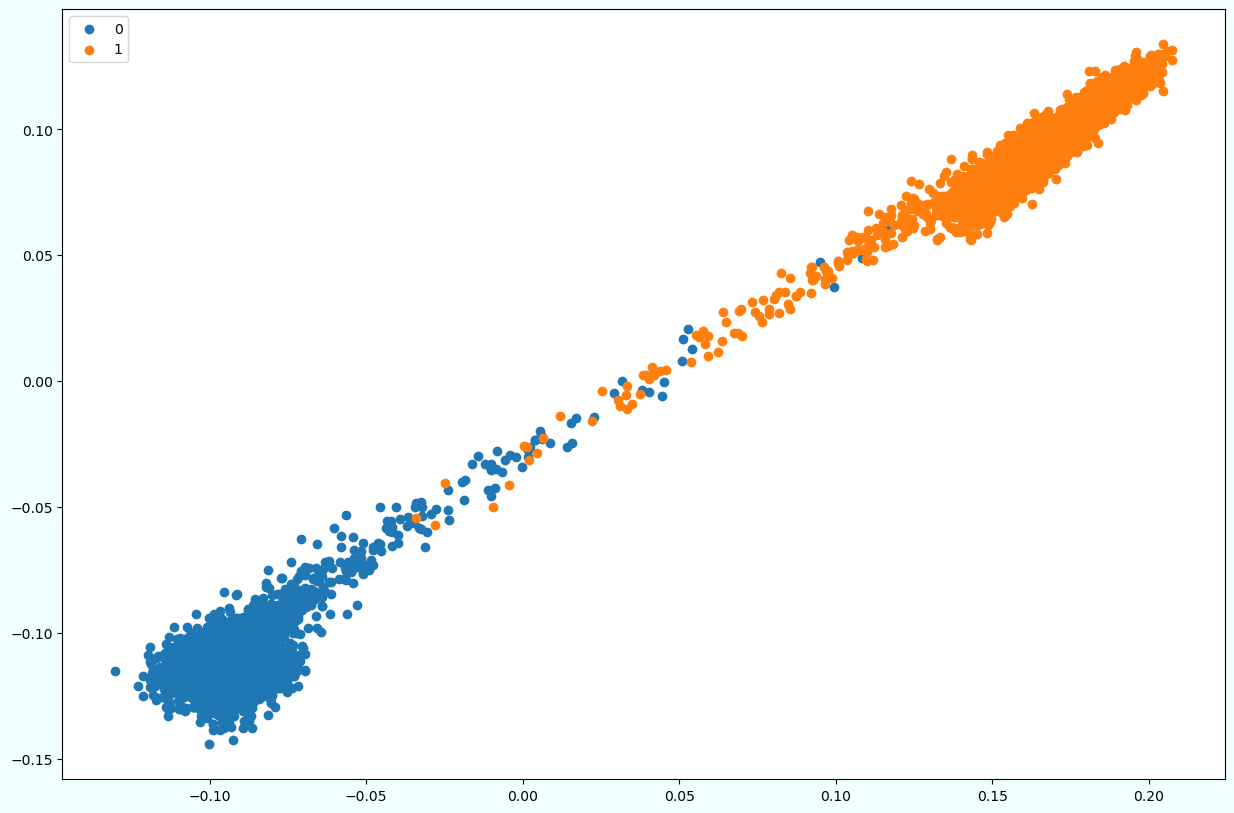

In [91]:
plt.figure(figsize=(15, 10), facecolor="azure")
for label in np.unique(labels):
    tmp = train_results[labels==label]
    plt.scatter(tmp[:, 0], tmp[:, 1], label=label)
    
plt.legend()
plt.show()

In [96]:
val_results = []
labels = []

model.eval()
with torch.no_grad():
    for img, label in tqdm(val_loader):
        val_results.append(model(img.to(device)).cpu().numpy())
        labels.append(label)
        
val_results = np.concatenate(val_results)
labels = np.concatenate(labels)
val_results.shape

  0%|          | 0/28 [00:00<?, ?it/s]

(1745, 128)

In [100]:
val_results

array([[-0.08668452, -0.09604667, -0.03655627, ...,  0.07415635,
        -0.01366393, -0.00174748],
       [ 0.17327894,  0.10108183,  0.10096855, ..., -0.03949774,
        -0.12256111,  0.0859118 ],
       [-0.09008282, -0.11843674, -0.05138342, ...,  0.09638835,
         0.01461258, -0.01      ],
       ...,
       [ 0.17232417,  0.0994585 ,  0.0938537 , ..., -0.02690967,
        -0.12005769,  0.08755985],
       [-0.09288175, -0.11237307, -0.0431173 , ...,  0.08021889,
        -0.00117096,  0.00176737],
       [ 0.04838616,  0.01135574,  0.02764722, ...,  0.0117276 ,
        -0.07457423,  0.0478496 ]], dtype=float32)

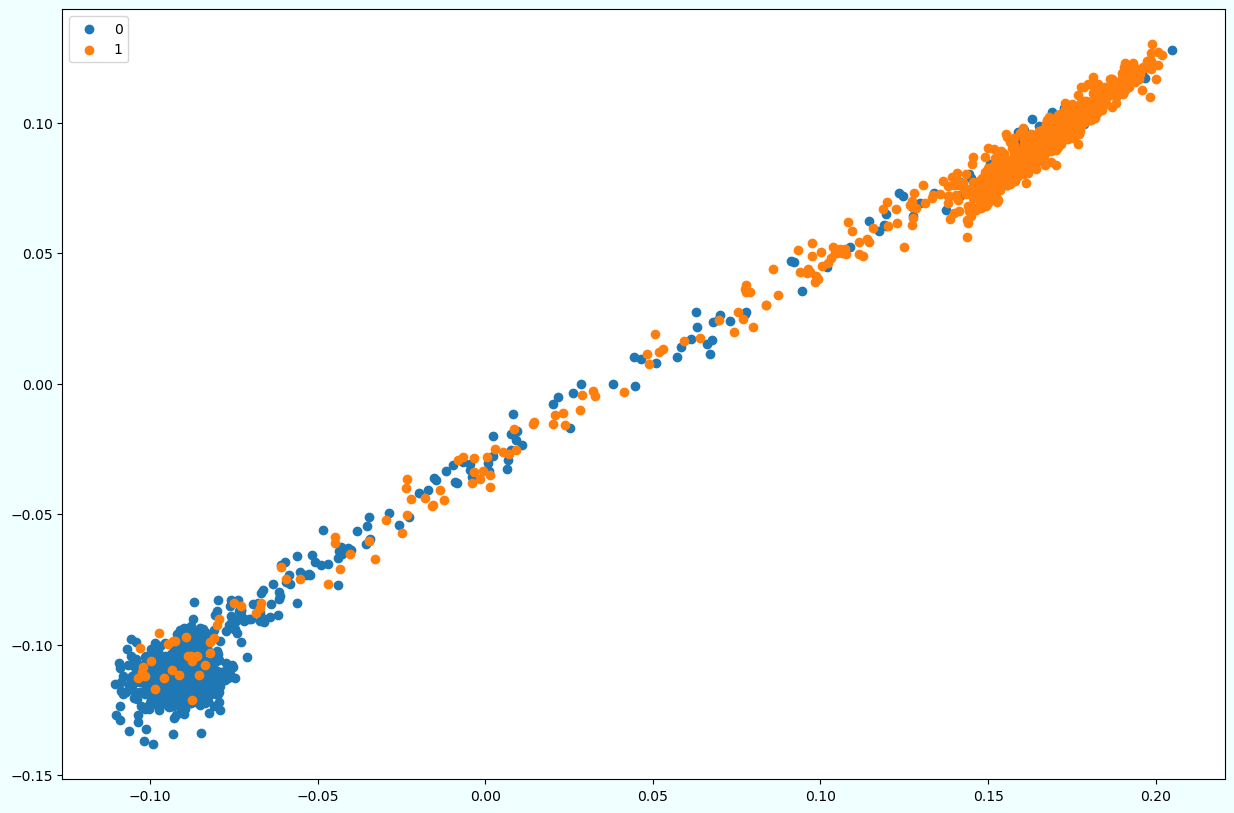

In [97]:
plt.figure(figsize=(15, 10), facecolor="azure")
for label in np.unique(labels):
    tmp = val_results[labels==label]
    plt.scatter(tmp[:, 0], tmp[:, 1], label=label)
    
plt.legend()
plt.show()

In [98]:
test_results = []
labels = []

model.eval()
with torch.no_grad():
    for img, label in tqdm(test_loader):
        test_results.append(model(img.to(device)).cpu().numpy())
        labels.append(label)
        
test_results = np.concatenate(test_results)
labels = np.concatenate(labels)
test_results.shape

  0%|          | 0/28 [00:00<?, ?it/s]

(1745, 128)

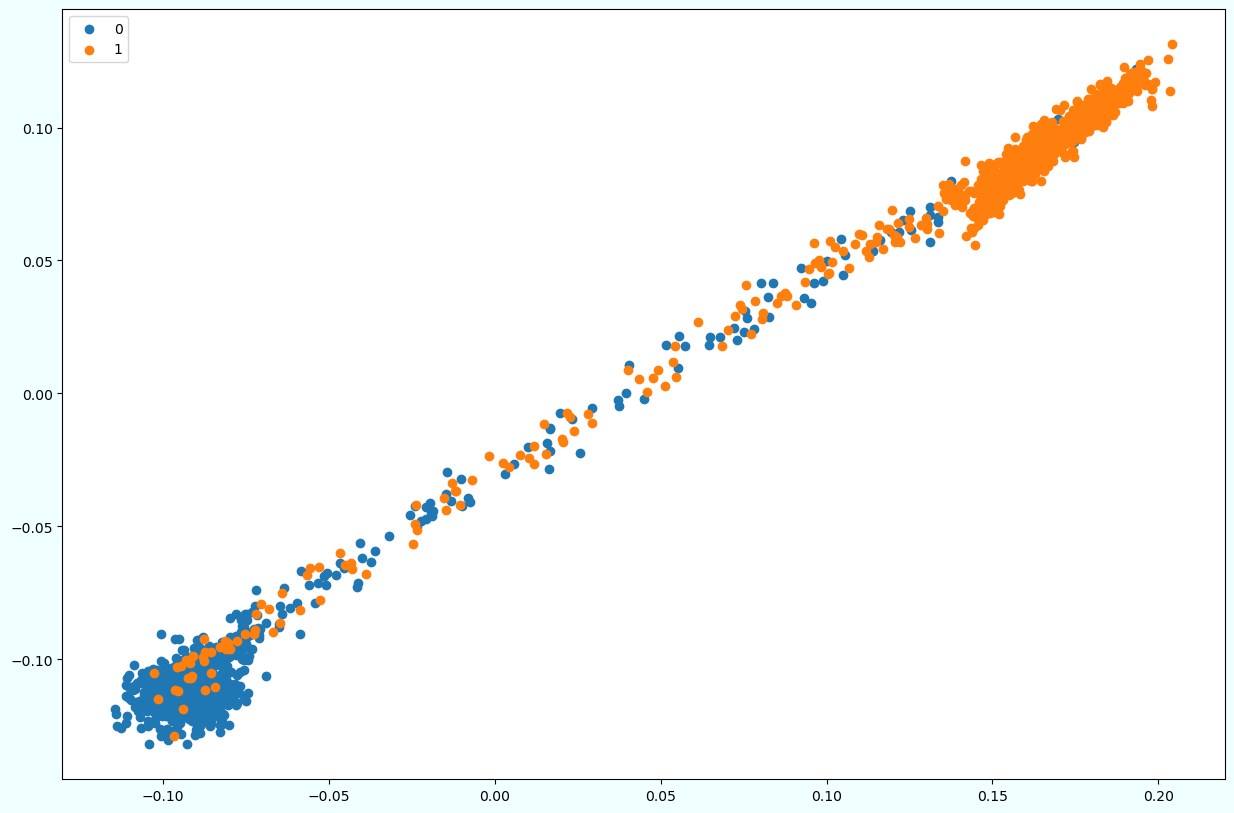

In [108]:
plt.figure(figsize=(15, 10), facecolor="azure")
for label in np.unique(labels):
    tmp = test_results[labels==label]
    plt.scatter(tmp[:, 0], tmp[:, 1], label=label)
    
plt.legend()
plt.show()

In [78]:
# def train(net, optim, train_loader, margin):
#     losses = []
#     accuracies = []
#     loss_fn = ContrastiveLoss(margin)
    
#     net.train()
#     for batch_i, (data, label) in enumerate(train_loader):
#         data, label = data.to(device), label.to(device)

#         optim.zero_grad()
#         output = net(data)
        
#         loss, dists = loss_fn(output, label)
#         losses.append(loss.item())

#         pred = []
#         for i in range(len(data)):
#             mask = dists[i].le(margin)
#             sel = torch.masked_select(label, mask.to(device))
#             pred.append(torch.mode(sel, 0).values)
#         pred = torch.Tensor(pred).to(device)

#         accuracy = pred.eq(label).sum() / len(data)
#         accuracies.append(accuracy.item())
        
#         loss.backward()
#         optim.step()
        
#     losses = torch.FloatTensor(losses)
#     accuracies = torch.FloatTensor(accuracies)
        
#     return torch.mean(accuracies), torch.mean(losses)

In [79]:
# def test(net, val_loader, margin):
#     accuracies = []

#     net.eval()
#     correct = 0
#     with torch.no_grad():
#         for batch_i, (data, label) in enumerate(val_loader):
#             data, label = data.to(device), label.to(device)

#             data_len = len(data)
#             output = net(data)
#             dists = torch.zeros(data_len, data_len)
#             for i in range(data_len):
#                 for j in range(data_len):
#                     dists[i][j] = euc_dist(output[i], output[j])

#             pred = []
#             for i in range(data_len):
#                 mask = dists[i].le(margin)
#                 sel = torch.masked_select(label, mask.to(device))
#                 pred.append(torch.mode(sel, 0).values)
#             pred = torch.Tensor(pred).to(device)

#             accuracy = pred.eq(label).sum() / len(data)
#             accuracies.append(accuracy.item())
#     accuracies = torch.FloatTensor(accuracies)

#     return torch.mean(accuracies)

In [32]:
model = Net(3, 2).to(device)
    
lr = 0.008289917846277375
mom = 0.7966154544005537
wd = 0.00013743896412874736
optim = opt.SGD(model.parameters(), lr=lr, momentum=mom, weight_decay=wd)
# optim = opt.Adam(model.parameters(), lr=lr)

batch_size = 64
# test_loader = DataLoader(test_data, batch_size=batch_size)

num_epochs = 20
print("Learning rate: "+ str(lr))
# print("Momentum: "+ str(mom))
# print("Weight decay: "+ str(wd))
print("Batch size: "+ str(batch_size))
print("Number of epochs: "+ str(num_epochs))

losses = []
accuracies = []
margin = 0.7
best_acc = 0
for epoch in range(num_epochs):
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    # train(model, optim, train_loader, batch_size, margin)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
#     test(model, val_loader, batch_size, margin)
    accuracy, loss = train(model, optim, train_loader, margin)
    val_accuracy = test(model, val_loader, margin)
    print("Epoch #" + str(epoch) + ":\tTrain accuracy: "+ str(accuracy) + "\tTrain loss: "+ str(loss) + "\tVal accuracy: "+ str(val_accuracy))
    
    losses.append(loss)
    accuracies.append(accuracy)
    
    if val_accuracy > best_acc:
        best_acc = val_accuracy
        print("Saving best model......")
        torch.save(model.state_dict(), "best_model_contrast.pt")

Learning rate: 0.008289917846277375
Batch size: 64
Number of epochs: 20
Epoch #0:	Train accuracy: tensor(0.5638)	Train loss: tensor(0.0872)	Val accuracy: tensor(0.5640)
Saving best model......
Epoch #1:	Train accuracy: tensor(0.5518)	Train loss: tensor(0.0809)	Val accuracy: tensor(0.5736)
Saving best model......
Epoch #2:	Train accuracy: tensor(0.5578)	Train loss: tensor(0.0806)	Val accuracy: tensor(0.5588)
Epoch #3:	Train accuracy: tensor(0.5629)	Train loss: tensor(0.0804)	Val accuracy: tensor(0.5537)
Epoch #4:	Train accuracy: tensor(0.5587)	Train loss: tensor(0.0806)	Val accuracy: tensor(0.5563)
Epoch #5:	Train accuracy: tensor(0.5617)	Train loss: tensor(0.0805)	Val accuracy: tensor(0.5651)
Epoch #6:	Train accuracy: tensor(0.5570)	Train loss: tensor(0.0806)	Val accuracy: tensor(0.5570)
Epoch #7:	Train accuracy: tensor(0.5565)	Train loss: tensor(0.0806)	Val accuracy: tensor(0.5562)
Epoch #8:	Train accuracy: tensor(0.5563)	Train loss: tensor(0.0805)	Val accuracy: tensor(0.5584)
Epoch #

KeyboardInterrupt: 

In [11]:
def objective(trial):
    model = Net(3, 2).to(device)
    
    lr = trial.suggest_float("learning_rate", 1e-6, 1e-2, log=True)
    mom = trial.suggest_float('momentum', 0.7, 0.99)
    wd = trial.suggest_float('weight_decay', 1e-5, 1e-1, log=True)
    optim = opt.SGD(model.parameters(), lr=lr, momentum=mom, weight_decay=wd)
    
    batch_size = trial.suggest_int('batch_size', 10, 100)
#     test_loader = DataLoader(test_data, batch_size=batch_size)
    
    num_epochs = trial.suggest_int('num_epochs', 10, 100)
    print("Learning rate: "+ str(lr))
    print("Momentum: "+ str(mom))
    print("Weight decay: "+ str(wd))
    print("Batch size: "+ str(batch_size))
    print("Number of epochs: "+ str(num_epochs))
    for epoch in range(num_epochs):
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
        train(model, optim, train_loader)
        accuracy = test(model, val_loader)
        print("Epoch #" + str(epoch) + ": Val accuracy: "+ str(accuracy))
        
        trial.report(accuracy, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
            
    return accuracy

In [ ]:
study = optuna.create_study(direction='maximize',
                            study_name='base-model-study',
                            storage='sqlite:///study.db',
                            load_if_exists=True)
study.optimize(objective, n_trials=68)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

# Display the study statistics
print("\nStudy statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

In [13]:
print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Best trial:
  Value:  0.9415472745895386
  Params: 
    batch_size: 41
    learning_rate: 0.008289917846277375
    momentum: 0.7966154544005537
    num_epochs: 69
    weight_decay: 0.00013743896412874736


In [40]:
model = Net(3, 2).to(device)
    
lr = 0.008289917846277375
mom = 0.7966154544005537
wd = 0.00013743896412874736
optim = opt.SGD(model.parameters(), lr=lr, momentum=mom, weight_decay=wd)

batch_size = 41
# test_loader = DataLoader(test_data, batch_size=batch_size)

num_epochs = 69
print("Learning rate: "+ str(lr))
print("Momentum: "+ str(mom))
print("Weight decay: "+ str(wd))
print("Batch size: "+ str(batch_size))
print("Number of epochs: "+ str(num_epochs))

losses = []
accuracies = []
for epoch in range(num_epochs):
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
    accuracy, loss = train(model, optim, train_loader)
    val_accuracy = test(model, val_loader)
    print("Epoch #" + str(epoch) + ":\tTrain accuracy: "+ str(accuracy) + "\tTrain loss: "+ str(loss) + "\tVal accuracy: "+ str(val_accuracy))
    
    losses.append(loss)
    accuracies.append(accuracy)

Learning rate: 0.008289917846277375
Momentum: 0.7966154544005537
Weight decay: 0.00013743896412874736
Batch size: 41
Number of epochs: 69
Epoch #0:	Train accuracy: tensor(0.5432)	Train loss: tensor(0.6878)	Val accuracy: tensor(0.5358, device='cuda:0')
Epoch #1:	Train accuracy: tensor(0.6257)	Train loss: tensor(0.6449)	Val accuracy: tensor(0.6728, device='cuda:0')
Epoch #2:	Train accuracy: tensor(0.6918)	Train loss: tensor(0.5805)	Val accuracy: tensor(0.7501, device='cuda:0')
Epoch #3:	Train accuracy: tensor(0.7470)	Train loss: tensor(0.5109)	Val accuracy: tensor(0.7742, device='cuda:0')
Epoch #4:	Train accuracy: tensor(0.7701)	Train loss: tensor(0.4753)	Val accuracy: tensor(0.7759, device='cuda:0')
Epoch #5:	Train accuracy: tensor(0.7994)	Train loss: tensor(0.4327)	Val accuracy: tensor(0.8258, device='cuda:0')
Epoch #6:	Train accuracy: tensor(0.8116)	Train loss: tensor(0.4025)	Val accuracy: tensor(0.8292, device='cuda:0')
Epoch #7:	Train accuracy: tensor(0.8331)	Train loss: tensor(0.36

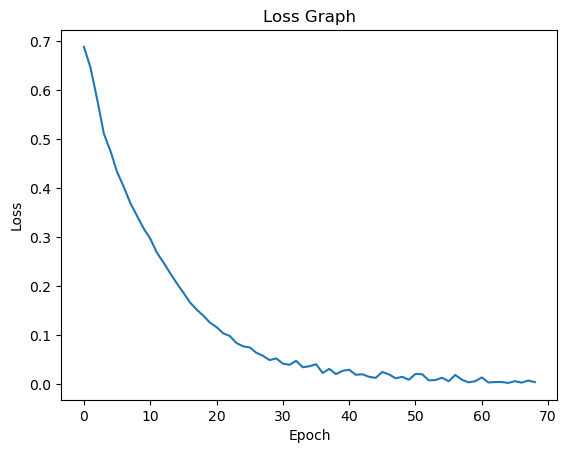

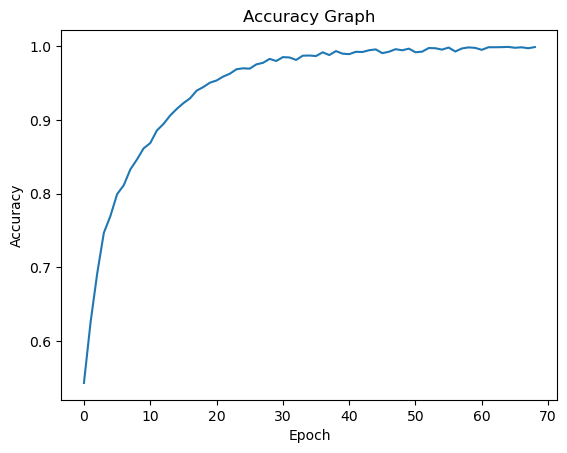

In [41]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.title('Loss Graph')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.plot(accuracies)
plt.title('Accuracy Graph')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [46]:
torch.save(model.state_dict(), '../results/base_model.pt')

In [13]:
test_data = AdienceDataset("../CFD/strat_test_CFD_MR.csv", "../CFD/cropped_CFD_MR/", transform=subtract_mean)
test_data.set_mean(mean)

In [14]:
model = Net(3, 2).to(device)
model.load_state_dict(torch.load('../Models/results/base_model.pt', map_location=torch.device('cpu')))
model.eval()

test_loader = DataLoader(test_data, batch_size=41)
accuracy = test(model, test_loader)
print("Test accuracy: "+ str(accuracy))

/home/sagnik/.local/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/home/sagnik/.local/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warni

Test accuracy: tensor(0.9600)


In [40]:
gens = []
confs = []

with open("./UTKFace/gender_pred.txt", 'r') as f:
    for line in f.readlines():
        line = line.strip('\n').split()

        if line[1] == 'Male':
            gens.append(0)
        elif line[1] == 'Female':
            gens.append(1)
        confs.append(float(line[2]))

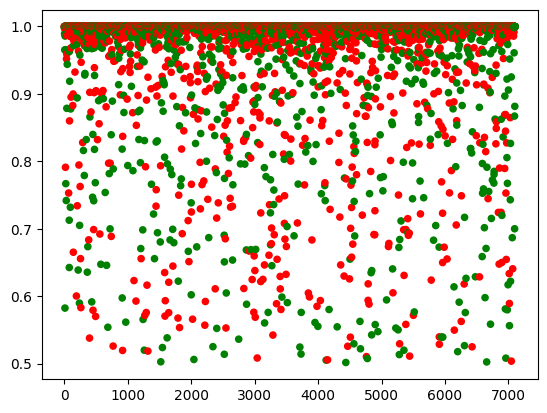

In [41]:
categories = np.array(gens)
colormap = np.array(['r', 'g'])
plt.scatter(list(range(len(gens))), confs, s=20, c=colormap[categories])
plt.show()